# Introduction & Motivation

This is the final notebook with a demonstration of the work of all our team members. In this work, we address the challenge of **multi‐drone route planning** over a realistic polygon‐based environment containing varied terrains (woods, water, industrial) and hazard zones (radar circles, restricted airspaces, etc.). Our key goal is to **combine** two powerful techniques:

1. Genetic Algorithm (GA) for global path planning and multi‐drone coordination.  
2. Reinforcement Learning (RL) environment for local, discrete movement control (turning, speeding up, etc.).

This two‐layer synergy ensures that large‐scale route decisions account for actual local costs (terrain/hazards) as discovered by an RL policy specialized in short segments. The **GA navigates the macro level** (selecting waypoints), while **RL refines the micro level** (step‐by‐step flight within each segment).  

We tested our integrated approach on a real polygon dataset from a CSV, gradually improving each module (map environment, genetic algorithm, and reinforcement learning) until we built a final training loop.

### Focus on Architecture & Integration

During this project, my main responsibility was to develop the program’s **architecture**, **integrate** the best approaches identified by my team members, and discover the **optimal way to combine** Reinforcement Learning (RL) and Genetic Algorithms (GA). While parts of the algorithm rely on existing GA and RL techniques, my core contribution was designing a modular architecture that unifies them.

I also introduced improvements in reward shaping, hazard sampling, and route representation to ensure that the GA’s macro‐level solutions remain feasible under RL’s local movement constraints. Ultimately, this structure supports multiple drones (organized into groups) operating in a real polygon map with scattered hazards, verifying that each route segment is flown both realistically and cost‐effectively by the RL agent.

## Notebook Structure

1. **Simple Architecture Main Modules**

  This phase defines the overall structure and tests key modules on an automatically generated pixel-based map. The environment representation includes basic terrain, obstacles, and hazards, serving as a foundation for initial pathfinding. A simulation coordinator integrates GA and RL components, allowing basic interaction between high-level planning and local adjustments.  
2. **Individual Modules Improvements**

  Each module is refined and adapted to work within a polygon-based environment. Terrain is represented using vectorized polygons, and different hazard types are introduced to reflect real-world constraints for drones. The GA is extended to incorporate polygon-based costs, while the RL model is trained to navigate within more complex polygonal structures.
3. **Real Data Demo**

  The final phase applies the developed architecture to a real dataset, integrating all modules into a fully functional system. The dataset is processed to extract terrain features, obstacles, and hazards, enabling a more realistic simulation. The polygon-based map environment is finalized, Reinforcement Learning models are fine-tuned for adaptive decision-making, and the Genetic Algorithm optimizes multi-drone route planning under real constraints.

# Libraries and dependencies

In [ ]:
!pip install stable_baselines3 shimmy shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import shapely.wkt
import random

from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import unary_union

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
from gymnasium import spaces

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
%matplotlib inline

import logging
logging.basicConfig(level=logging.INFO)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Simple Architecture Main Modules

- Genetic algorithm solves the large‐scale problem of picking good global waypoints (minimizing detection, maximizing safe coverage)
- RL policy solves the "last‐mile" or "local decisions" problem, reacting to immediate threats and small variations in real time

#### Map/Environment Representation

In [ ]:
class MapEnvironment:
    """
    Stores a 2D grid representing terrain, hazards, and coverage.
    Provides a get_cost(x, y) method to combine these factors.
    """
    def __init__(self, width, height, terrain_map, hazard_map, coverage_map):
        """
        width, height: dimensions of the map
        terrain_map: 2D array of terrain types
        hazard_map: 2D array with penalty from threats
        coverage_map: 2D array with coverage bonus
        """
        self.width = width
        self.height = height
        self.terrain_map = terrain_map
        self.hazard_map = hazard_map
        self.coverage_map = coverage_map

    def get_cost(self, x, y):
        """
        Returns a combined cost (penalty) or negative reward for cell (x,y).
        If out of bounds, returns large penalty.
        """
        if not self.in_bounds(x, y):
            return 1000.0
        terrain_pen = self._terrain_penalty(self.terrain_map[x, y])
        hazard_pen = self.hazard_map[x, y]
        coverage_bon = self.coverage_map[x, y]
        cost = terrain_pen + hazard_pen - coverage_bon
        return cost

    def in_bounds(self, x, y):
        return 0 <= x < self.width and 0 <= y < self.height

    def _terrain_penalty(self, terrain_type):
        """
        Penalty or cost for different terrain.
        0 = forest -> negative (reward because it offers cover),
        1 = grass  -> neutral,
        2 = shrubs -> slight negative,
        3 = mountain -> some small penalty,
        4 = water -> bigger penalty.
        """
        if terrain_type == 0:  # forest
            return -0.5
        elif terrain_type == 1:  # grass
            return 0.0
        elif terrain_type == 2:  # shrubs
            return -0.2
        elif terrain_type == 3:  # mountain
            return 0.3
        elif terrain_type == 4:  # water
            return 1.0
        return 0.0

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Genetic Algorithm

In [ ]:
class GeneticPlanner:
    """
    A simple GA to plan routes (sequences of waypoints).
    Each "individual" is a list of routes (one route per drone).
    """
    def __init__(self, map_env, start_points, target_points, n_drones, n_groups,
                 population_size=50):
        self.map_env = map_env
        self.start_points = start_points
        self.target_points = target_points
        self.n_drones = n_drones
        self.n_groups = n_groups
        self.population_size = population_size
        self.population = []

        self._init_population()

    def _init_population(self):
        """
        Initialize random population of candidate solutions.
        """
        for _ in range(self.population_size):
            individual = []
            for drone_idx in range(self.n_drones):
                route = self._random_route(self.start_points[drone_idx],
                                           self.target_points[drone_idx])
                individual.append(route)
            self.population.append(individual)

    def _random_route(self, start, end, num_waypoints=5):
        """
        Creates a random route from start to end with intermediate random waypoints.
        """
        route = [start]
        for _ in range(num_waypoints):
            x = random.randint(0, self.map_env.width - 1)
            y = random.randint(0, self.map_env.height - 1)
            route.append((x, y))
        route.append(end)
        return route

    def evaluate_fitness(self, individual):
        """
        Calculate a cost for the entire set of drone routes in 'individual'.
        Summation of cost for each route.
        """
        total_cost = 0.0
        for route in individual:
            route_cost = 0.0
            for i in range(len(route) - 1):
                x1, y1 = route[i]
                x2, y2 = route[i+1]
                # distance penalty
                dist = np.hypot(x2 - x1, y2 - y1)
                # map environment cost at the next cell
                cell_cost = self.map_env.get_cost(x2, y2)
                route_cost += dist + cell_cost
            total_cost += route_cost
        return total_cost

    def selection(self):
        """
        Simple survival-of-the-fittest: keep the top half of the population.
        """
        scored_pop = [(ind, self.evaluate_fitness(ind)) for ind in self.population]
        scored_pop.sort(key=lambda x: x[1])  # sort by ascending cost
        # Keep top half
        survivors = scored_pop[:len(scored_pop)//2]
        self.population = [s[0] for s in survivors]

    def crossover(self, parent1, parent2):
        """
        Crossover each route (one route per drone). Single cut point.
        """
        child1, child2 = [], []
        for r1, r2 in zip(parent1, parent2):
            cut = random.randint(1, min(len(r1), len(r2)) - 1)
            new_route1 = r1[:cut] + r2[cut:]
            new_route2 = r2[:cut] + r1[cut:]
            child1.append(new_route1)
            child2.append(new_route2)
        return child1, child2

    def mutate(self, individual, mutation_rate=0.1):
        """
        Randomly mutate waypoints in each route.
        """
        for route in individual:
            if random.random() < mutation_rate:
                # pick a random waypoint (not start/end)
                if len(route) > 2:
                    idx = random.randint(1, len(route) - 2)
                    x = random.randint(0, self.map_env.width - 1)
                    y = random.randint(0, self.map_env.height - 1)
                    route[idx] = (x, y)
        return individual

    def evolve(self, generations=20, mutation_rate=0.1):
        """
        Run the main GA loop for 'generations' iterations.
        """
        for gen in range(generations):
            self.selection()

            new_pop = []
            while len(new_pop) < self.population_size:
                parents = random.sample(self.population, 2)
                c1, c2 = self.crossover(parents[0], parents[1])
                new_pop.extend([c1, c2])

            for i in range(len(new_pop)):
                new_pop[i] = self.mutate(new_pop[i], mutation_rate)

            self.population = new_pop

        # return best solution
        scored_pop = [(ind, self.evaluate_fitness(ind)) for ind in self.population]
        best_ind, best_score = min(scored_pop, key=lambda x: x[1])
        return best_ind, best_score

#### RL Environment

In [ ]:
class DroneEnv(gym.Env):
    """
    A simplified single-drone environment for local/tactical decisions.
    Observations: [x, y, speed, heading, hazard, coverage].
    Actions: [delta_heading, delta_speed].
    """
    def __init__(self, map_env, drone_id=0, initial_state=None):
        super().__init__()
        self.map_env = map_env
        self.drone_id = drone_id

        # Observation: 6D vector
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32
        )

        # Action: 2D continuous (delta_heading, delta_speed)
        self.action_space = spaces.Box(
            low=np.array([-1.0, -1.0], dtype=np.float32),
            high=np.array([1.0, 1.0], dtype=np.float32),
            dtype=np.float32
        )

        # Initial state (x, y, speed, heading, hazard, coverage)
        if initial_state is None:
            self.initial_state = np.zeros((6,), dtype=np.float32)
        else:
            self.initial_state = np.array(initial_state, dtype=np.float32)

        self.state = None
        self.done = False

    def reset(self, seed=None, options=None):
        """
        Gymnasium reset: must return (observation, info).
        """
        super().reset(seed=seed)  # for reproducible seeding, if desired
        self.state = self.initial_state.copy()
        self.done = False
        # 'info' can contain diagnostic data or debugging info
        return self.state, {}

    def step(self, action):
        """
        Must return (observation, reward, done, truncated, info).
        """
        heading_change, speed_change = action
        x, y, speed, heading, hazard, coverage = self.state

        # Update heading & speed
        heading += heading_change
        speed = max(0, speed + speed_change)

        # Move drone
        dx = speed * np.cos(heading)
        dy = speed * np.sin(heading)
        x_new = x + dx
        y_new = y + dy

        # Calculate cost from the map
        cost = self.map_env.get_cost(int(x_new), int(y_new))
        reward = -cost  # negative cost as reward

        # Check if out of bounds
        if not self.map_env.in_bounds(int(x_new), int(y_new)):
            reward -= 10.0
            self.done = True

        # Update hazard/coverage from the map
        new_hazard = self.map_env.hazard_map[
            int(x_new) % self.map_env.width,
            int(y_new) % self.map_env.height
        ]
        new_coverage = self.map_env.coverage_map[
            int(x_new) % self.map_env.width,
            int(y_new) % self.map_env.height
        ]

        # Build next state
        self.state = np.array([x_new, y_new, speed, heading, new_hazard, new_coverage], dtype=np.float32)

        # Example condition to end the episode
        done = self.done
        truncated = False  # set True for a time-limit or other "truncation" condition

        if np.hypot(x_new - x, y_new - y) > 10:
            done = True

        info = {}
        return self.state, reward, done, truncated, info

    def render(self):
        """
        Implementation of the visualization for the drone.
        """
        pass

In [ ]:
def train_local_agent(map_env, drone_id, timesteps=5000):
    """
    Train a PPO agent on the DroneEnv using stable_baselines3.
    """
    env = DroneEnv(map_env, drone_id=drone_id, initial_state=[0,0,0,0,0,0])
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=timesteps)
    return model

#### Simulation Coordinator

In [ ]:
def visualize_map_and_path(
    map_env,
    route=None,
    title=None,
    hazard_overlay=True,
    hazard_alpha=0.4
):
    """
    Visualize:
      - Terrain as color-coded background
      - Hazard zones overlaid in red
      - The route (list of (x, y) waypoints) in magenta

    Args:
      map_env: MapEnvironment instance, containing terrain_map, hazard_map, etc.
      route: optional list of (x, y) waypoints to be plotted.
      title: optional title string for the plot
      hazard_overlay: if True, overlay hazards in red
      hazard_alpha: transparency level for the hazard overlay
    """
    # Prepare an RGB image array [height, width, 3]
    height = map_env.height
    width = map_env.width
    img = np.zeros((height, width, 3), dtype=np.float32)

    # Define colors for each terrain type
    # [R, G, B] in [0..1]
    terrain_colors = {
        0: [0.0, 0.5, 0.0],   # forest
        1: [0.8, 0.8, 0.4],   # grass
        2: [0.5, 0.7, 0.2],   # shrubs
        3: [0.5, 0.5, 0.5],   # mountain
        4: [0.2, 0.2, 1.0],   # water
    }

    # Fill img with terrain colors
    for x in range(width):
        for y in range(height):
            ttype = map_env.terrain_map[x, y]
            color = terrain_colors.get(ttype, [0.0, 0.0, 0.0])
            # Remember: image is indexed as [y, x], not [x, y]
            img[y, x, :] = color

    # Scale hazard penalty to [0..1] for overlay
    if hazard_overlay:
        hazard_max = np.max(map_env.hazard_map) or 1.0
        hazard_norm = map_env.hazard_map / (hazard_max + 1e-9)

        # Expand to shape (height, width, 1)
        hazard_norm_3d = hazard_norm.reshape(width, height).T[..., None]  # transpose to [y, x]
        # We add red = hazard_norm_3d * 1.0
        # The alpha blending: out_color = base*(1-alpha) + overlay*alpha
        # Here we do a naive overlay on the red channel for demonstration
        overlay_img = img.copy()
        overlay_img[..., 0] = 1.0  # red channel
        img = (1 - hazard_alpha*hazard_norm_3d) * img + (hazard_alpha*hazard_norm_3d) * overlay_img

    # Plot with matplotlib
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img, origin="upper")

    # If a route is given, plot it over the map
    # route is a list of (x, y) coords
    if route:
        xs = [p[0] for p in route]
        ys = [p[1] for p in route]
        # Because imshow is row=y, col=x, we invert them when plotting
        ax.plot(xs, ys, color="magenta", marker="o", linewidth=2, markersize=4)

    if title:
        ax.set_title(title)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    ax.invert_yaxis()

    plt.show()

In [ ]:
class Simulator:
    """
    High-level simulation:
      1) Uses GA to find global routes
      2) Uses RL to handle local control
    """
    def __init__(self, map_env, planner, rl_models):
        self.map_env = map_env
        self.planner = planner
        self.rl_models = rl_models

    def run_simulation(self):
        # Evolve best route
        best_route, best_score = self.planner.evolve(generations=5)
        print("GA Best Route with cost:", best_score)

        # For each drone, we can simulate local moves with RL if desired
        for drone_idx, route in enumerate(best_route):
            print(f"--- Drone {drone_idx} route:")
            print(route)
            visualize_map_and_path(
                self.map_env,
                route=route,
                title=f"Best GA route (cost={best_score:.2f})"
            )
            model = self.rl_models[drone_idx]
            # W'd segment route into smaller steps
            # and let RL handle each segment. For now, we just show the route

        print("Simulation complete.")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Main Execution

In [ ]:
def main():
    width, height = 100, 100

    # Randomly create terrain
    terrain_map = np.random.randint(0, 5, (width, height))

    # Hazard map
    hazard_map = np.zeros((width, height), dtype=np.float32)
    for _ in range(10):
        cx, cy = np.random.randint(0, width), np.random.randint(0, height)
        r = np.random.randint(5, 15)
        for x in range(cx-r, cx+r):
            for y in range(cy-r, cy+r):
                if 0 <= x < width and 0 <= y < height:
                    dist = np.hypot(x - cx, y - cy)
                    if dist < r:
                        hazard_map[x,y] += (1 - dist/r)*2.0  # some gradient

    # Coverage map
    coverage_map = np.zeros((width, height), dtype=np.float32)
    coverage_map[terrain_map == 0] = np.random.uniform(0.2, 1.0, (terrain_map==0).sum())

    # Build environment
    map_env = MapEnvironment(width, height, terrain_map, hazard_map, coverage_map)

    # 2 drones, 1 group
    n_drones = 2
    n_groups = 1
    start_points = [(0,0), (10,0)]
    target_points = [(90,90), (95,95)]

    # GA planner
    planner = GeneticPlanner(map_env, start_points, target_points,
                            n_drones, n_groups, population_size=20)

    # Train RL for each drone
    rl_models = {}
    for drone_idx in range(n_drones):
        print(f"Training RL model for Drone {drone_idx}...")
        rl_models[drone_idx] = train_local_agent(map_env, drone_id=drone_idx, timesteps=3000)

    # Run simulation
    sim = Simulator(map_env, planner, rl_models)
    sim.run_simulation()

Training RL model for Drone 0...


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Training RL model for Drone 1...
GA Best Route with cost: 378.28984697767464
--- Drone 0 route:
[(0, 0), (51, 17), (45, 34), (45, 48), (84, 38), (86, 66), (90, 90)]


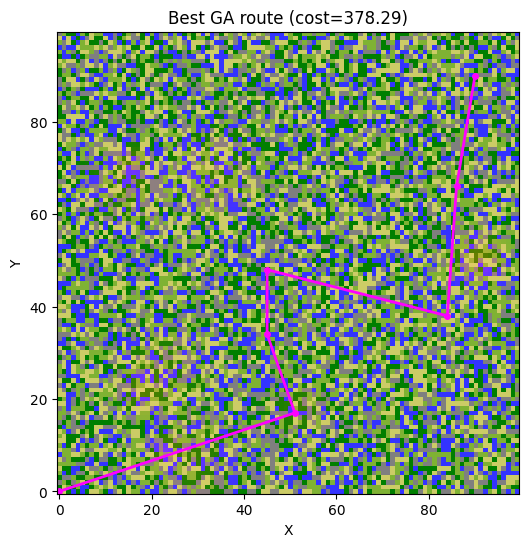

--- Drone 1 route:
[(10, 0), (8, 7), (42, 31), (63, 29), (69, 4), (72, 73), (95, 95)]


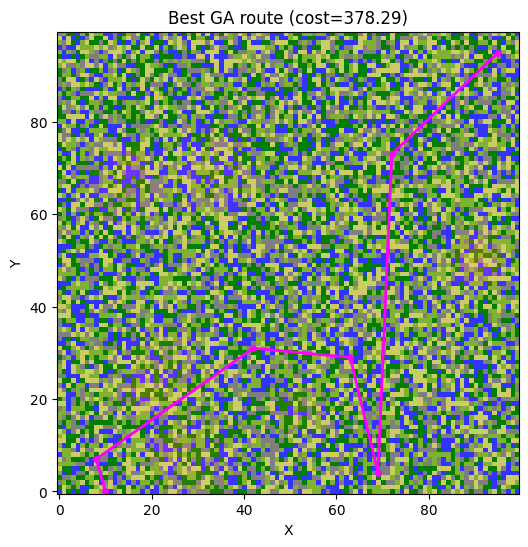

Simulation complete.


In [ ]:
main()

# Individual Modules Improvements
1. Transform a map from pixel-by-pixel representation to coordinate polygons
2. Setting up joint work of GA and RL, optimisation of route settings for several groups of drones
3. Parallelisation of processes to speed up and optimise calculations
4. Introduction of additional weights for each of the parameters of fines and rewards
5. Implementation and integration of the best techniques, algorithms and settings identified from individual research

### Polygon‐based Environment

In [ ]:
class PolygonMapEnvironment:
    """
    Stores a list of polygons for each terrain type, plus
    hazard zones (circular polygons), plus optional building polygons.
    """
    def __init__(self, terrain_polygons, hazard_circles, building_polygons=None):
        """
        terrain_polygons: dict of {terrain_type: [list of shapely Polygons]}
        hazard_circles: list of shapely Polygons (circular) representing hazard zones
        building_polygons: optional list of shapely Polygons for industrial buildings
        """
        self.terrain_polygons = terrain_polygons
        self.hazard_circles = hazard_circles
        self.building_polygons = building_polygons if building_polygons else []

        self.hazard_union = unary_union(self.hazard_circles) if self.hazard_circles else None

    def get_cost(self, x, y):
        """
        Return a 'cost' (penalty) for being at (x,y).
        Negative cost => reward, positive => penalty.
        """
        point = Point(x, y)

        cost = 0.0

        terrain_type = self._find_terrain_type(point)
        if terrain_type == "forest":
            cost -= 0.5  # coverage reward
        elif terrain_type == "grass":
            cost += 0.0
        elif terrain_type == "mountain":
            cost += 0.3
        elif terrain_type == "water":
            cost += 1.0

        # Hazard penalty
        if self.hazard_union and self.hazard_union.contains(point):
            cost += 5.0

        # Buildings
        for bpoly in self.building_polygons:
            if bpoly.contains(point):
                # might reduce detection => negative cost => reward
                cost -= 0.2

        return cost

    def _find_terrain_type(self, point):
        """
        Identify which terrain polygon the point belongs to.
        You could do a more advanced check if polygons overlap, or store them in a spatial index.
        """
        for ttype, plist in self.terrain_polygons.items():
            for poly in plist:
                if poly.contains(point):
                    return ttype
        return "grass"  # default if none contain it

    def in_bounds(self, x, y, boundary_polygon=None):
        """
        If you want a bounding polygon for your entire map, define it here.
        For now, we'll assume we just check if (x,y) is in some bounding region or skip.
        """
        if boundary_polygon is not None:
            return boundary_polygon.contains(Point(x, y))
        return True

In [ ]:
def create_sample_polygon_map():
    """
    Create some random polygons for forest, water, mountains,
    plus a few hazard circles and building polygons.
    """

    boundary = Polygon([(0,0), (100,0), (100,100), (0,100)])

    forest_poly = Polygon([(10,10), (40,10), (40,40), (10,40)])  # a simple square
    mountain_poly = Polygon([(60,60), (80,60), (80,80), (60,80)])
    water_poly = Polygon([(20,60), (30,60), (30,80), (20,80)])  # another square for demo

    # Terrain dictionary
    terrain_polygons = {
        "forest": [forest_poly],
        "mountain": [mountain_poly],
        "water": [water_poly]
        # anything not in these polygons => "grass" by default
    }

    # Hazard circles
    hazard_circles = []
    center1 = Point(50, 50)
    circle1 = center1.buffer(8.0)  # radius=8
    center2 = Point(75, 25)
    circle2 = center2.buffer(10.0)
    hazard_circles.append(circle1)
    hazard_circles.append(circle2)

    # Buildings: let's define a small industrial building polygon
    building1 = Polygon([(15, 45), (25,45), (25,55), (15,55)])
    building2 = Polygon([(70, 10), (90, 10), (90, 20), (70,20)])
    building_polygons = [building1, building2]

    # Build environment
    map_env = PolygonMapEnvironment(
        terrain_polygons=terrain_polygons,
        hazard_circles=hazard_circles,
        building_polygons=building_polygons
    )

    return map_env, boundary

In [ ]:
def plot_polygon_map(
    map_env,
    boundary_polygon=None,
    path=None,
    title="Polygon Map Visualization"
):
    """
    Visualize terrain polygons, hazard circles, building polygons,
    plus an optional path (a list of (x, y) points).
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot bounding polygon if provided
    if boundary_polygon:
        xs, ys = boundary_polygon.exterior.xy
        ax.plot(xs, ys, color='black', linewidth=2)
        ax.fill(xs, ys, color='lightgreen', alpha=0.3)

    # Color definitions
    terrain_colors = {
        "forest": "green",
        "mountain": "gray",
        "water": "blue",
    }

    # Plot terrain polygons
    for ttype, plist in map_env.terrain_polygons.items():
        color = terrain_colors.get(ttype, "lightgreen")  # default for grass
        for poly in plist:
            xcoords, ycoords = poly.exterior.xy
            ax.fill(xcoords, ycoords, color=color, alpha=0.4, label=ttype)

    # Plot hazard circles in red
    for h in map_env.hazard_circles:
        hx, hy = h.exterior.xy
        ax.fill(hx, hy, color="red", alpha=0.3)

    # Plot buildings in dark brown
    for bpoly in map_env.building_polygons:
        bx, by = bpoly.exterior.xy
        ax.fill(bx, by, color="brown", alpha=0.6)

    # Plot path if provided
    if path:
        xs = [p[0] for p in path]
        ys = [p[1] for p in path]
        ax.plot(xs, ys, color='magenta', marker='o', linewidth=2, markersize=4)

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', 'box')
    plt.show()

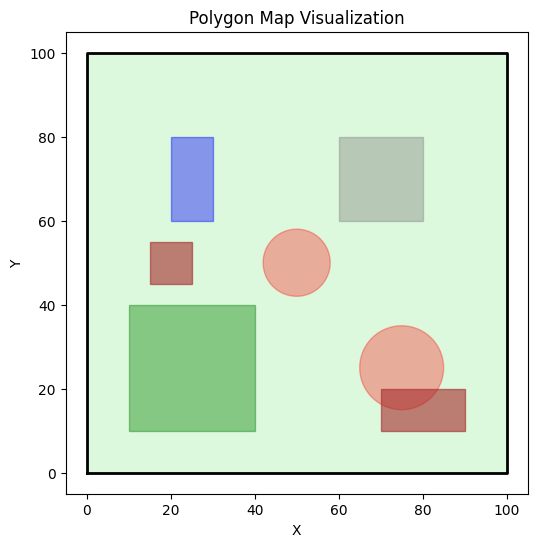

In [ ]:
map_env, boundary = create_sample_polygon_map()
plot_polygon_map(map_env, boundary_polygon=boundary)

### Polygon‐based GA

In [ ]:
def euclidean_distance(p1, p2):
    return np.hypot(p2[0] - p1[0], p2[1] - p1[1])

class GeneticPlannerPolygon:
    """
    A genetic algorithm that plans a route (series of waypoints) from start to goal
    while avoiding high-cost regions in the given map environment.
    """
    def __init__(
        self,
        map_env,
        start,
        goal,
        population_size=30,
        num_waypoints=5,
        selection_type="tournament",
        crossover_type="single_point",
        mutation_type="random"
    ):
        self.map_env = map_env
        self.start = start
        self.goal = goal
        self.population_size = population_size
        self.num_waypoints = num_waypoints
        self.selection_type = selection_type
        self.crossover_type = crossover_type
        self.mutation_type = mutation_type

        self.population = []
        self._init_population()

    def _init_population(self):
        """Initialize population with random waypoints."""
        for _ in range(self.population_size):
            individual = [self.start]
            for _ in range(self.num_waypoints):
                rx = random.uniform(0, 100)
                ry = random.uniform(0, 100)
                individual.append((rx, ry))
            individual.append(self.goal)
            self.population.append(individual)

    def evaluate_fitness(self, route):
        """Calculate the total cost of a given route (distance + map penalty)."""
        total_cost = 0.0
        for i in range(len(route) - 1):
            x1, y1 = route[i]
            x2, y2 = route[i+1]
            dist = euclidean_distance(route[i], route[i+1])
            cost = self.map_env.get_cost(x2, y2)
            total_cost += dist + cost
        return total_cost

    def selection(self):
        """Selection method: tournament or roulette selection."""
        scored = [(ind, self.evaluate_fitness(ind)) for ind in self.population]
        scored.sort(key=lambda x: x[1])  # Sort by fitness (lower is better)

        if self.selection_type == "tournament":
            return self.tournament_selection(scored)
        elif self.selection_type == "roulette":
            return self.roulette_selection(scored)
        return [x[0] for x in scored[:len(scored)//2]]  # Default: top half selection

    def tournament_selection(self, scored, tournament_size=5):
        """Tournament selection."""
        selected = []
        for _ in range(len(scored) // 2):
            competitors = random.sample(scored, tournament_size)
            winner = min(competitors, key=lambda x: x[1])
            selected.append(winner[0])
        return selected

    def roulette_selection(self, scored):
        """Roulette wheel selection."""
        min_fitness = min(x[1] for x in scored)
        adjusted_fitness = [(x[1] - min_fitness + 1e-6) for x in scored]
        total_fitness = sum(1 / f for f in adjusted_fitness)
        probabilities = [(1 / f) / total_fitness for f in adjusted_fitness]
        selected_indices = np.random.choice(len(scored), size=len(scored)//2, p=probabilities, replace=False)
        selected = [scored[i][0] for i in selected_indices]
        return selected

    def crossover(self, p1, p2):
        """Crossover method: single-point or uniform crossover."""
        if self.crossover_type == "uniform":
            return self.uniform_crossover(p1, p2)
        return self.single_point_crossover(p1, p2)

    def single_point_crossover(self, p1, p2):
        """Single-point crossover."""
        cut = random.randint(1, len(p1)-2)
        c1 = p1[:cut] + p2[cut:]
        c2 = p2[:cut] + p1[cut:]
        c1[0], c1[-1] = p1[0], p1[-1]
        c2[0], c2[-1] = p1[0], p1[-1]
        return c1, c2

    def uniform_crossover(self, p1, p2):
        """Uniform crossover."""
        c1, c2 = [p1[0]], [p2[0]]
        for i in range(1, len(p1)-1):
            c1.append(p1[i] if random.random() < 0.5 else p2[i])
            c2.append(p2[i] if random.random() < 0.5 else p1[i])
        c1.append(p1[-1])
        c2.append(p1[-1])
        return c1, c2

    def mutate(self, route, rate=0.1):
        """Mutation method: random or small perturbation."""
        if self.mutation_type == "small_perturb":
            return self.small_perturb_mutation(route, rate)
        return self.random_mutation(route, rate)

    def random_mutation(self, route, rate):
        """Randomly replace intermediate waypoints."""
        for i in range(1, len(route)-1):
            if random.random() < rate:
                route[i] = (random.uniform(0, 100), random.uniform(0, 100))
        return route

    def small_perturb_mutation(self, route, rate):
        """Slightly perturb waypoints instead of replacing them."""
        for i in range(1, len(route)-1):
            if random.random() < rate:
                dx, dy = random.uniform(-5, 5), random.uniform(-5, 5)
                route[i] = (max(0, min(100, route[i][0] + dx)), max(0, min(100, route[i][1] + dy)))
        return route

    def evolve(self, generations=20, mutation_rate=0.1):
        """Main evolution loop."""
        for _ in range(generations):
            self.population = self.selection()
            new_pop = []
            while len(new_pop) < self.population_size:
                p1, p2 = random.sample(self.population, 2)
                c1, c2 = self.crossover(p1, p2)
                c1 = self.mutate(c1, mutation_rate)
                c2 = self.mutate(c2, mutation_rate)
                new_pop.extend([c1, c2])
            self.population = new_pop
        best_route = min(self.population, key=self.evaluate_fitness)
        best_fitness = self.evaluate_fitness(best_route)
        return best_route, best_fitness

In [ ]:
def test_ga_polygon_map():
    map_env, boundary = create_sample_polygon_map()
    start, goal = (5, 5), (95, 95)

    for selection in ["tournament", "roulette"]:
        for crossover in ["single_point", "uniform"]:
            for mutation in ["random", "small_perturb"]:
                planner = GeneticPlannerPolygon(map_env, start, goal, 30, 5, selection, crossover, mutation)
                best_route, best_fitness = planner.evolve()
                print(f"Best route ({selection}, {crossover}, {mutation}): {best_route}")
                print(f"Fitness: {best_fitness}")
                plot_polygon_map(map_env, boundary, path=best_route, title=f"{selection}, {crossover}, {mutation}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best route (tournament, single_point, random): [(5, 5), (19.936381160308713, 36.94077613668788), (27.241662176480077, 39.40988552436928), (24.79454869743044, 46.04781458828451), (52.14339905048172, 63.23484773882423), (64.04415829604811, 74.47943809053639), (95, 95)]
Fitness: 134.95998372912186


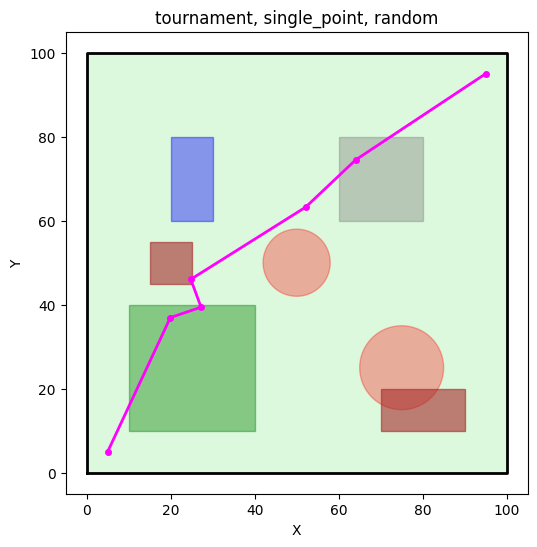

Best route (tournament, single_point, small_perturb): [(5, 5), (39.14898670861909, 10.923747236296055), (48.08173627717056, 13.098134253132397), (50.5025866464872, 16.13825917917536), (56.166429682473485, 22.526597112781793), (88.10530635049895, 83.32526818408039), (95, 95)]
Fitness: 138.01226635919184


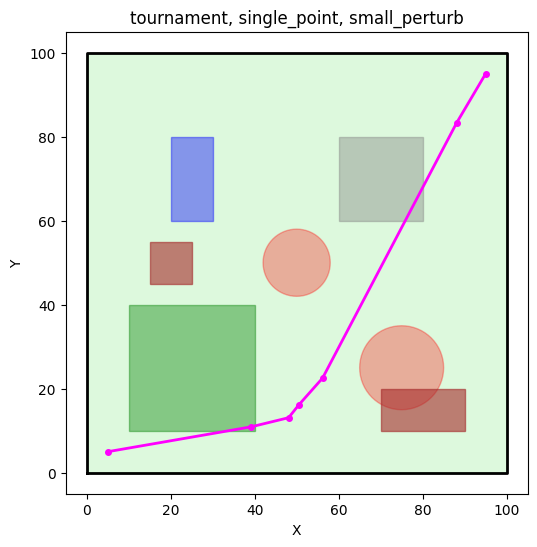

Best route (tournament, uniform, random): [(5, 5), (21.820166080312497, 23.400383607011843), (21.065959924311827, 33.746082821100764), (29.68925267912672, 58.489762101942844), (40.71502688926984, 67.68704182777603), (81.73056909633961, 90.99695817371313), (95, 95)]
Fitness: 135.90099035125965


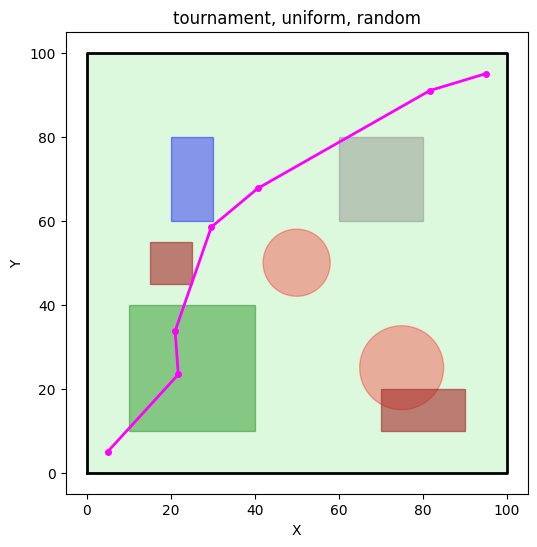

Best route (tournament, uniform, small_perturb): [(5, 5), (24.32580920620398, 41.91382936127131), (25.090734040329288, 41.853298722558264), (27.61840895783496, 42.44276443182714), (72.02751979946771, 54.799563800357376), (81.05221781921031, 62.071696772970995), (95, 95)]
Fitness: 138.4763081710483


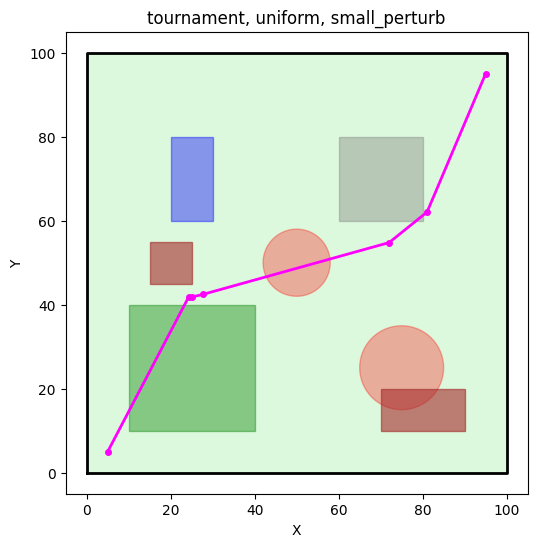

Best route (roulette, single_point, random): [(5, 5), (13.336256512715828, 16.304507118521606), (20.082827888046594, 28.74802029866662), (61.87095092141328, 47.03453604304957), (64.50613797005636, 45.78600176716444), (82.02757985416645, 73.92541323420775), (95, 95)]
Fitness: 133.62637947056027


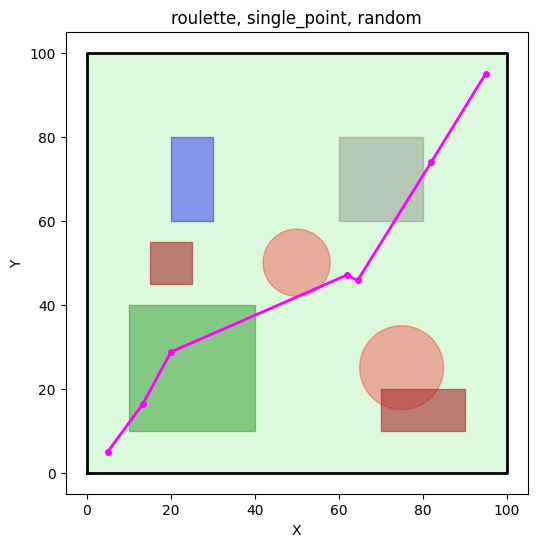

Best route (roulette, single_point, small_perturb): [(5, 5), (25.45332142456705, 20.73162643531157), (61.49714529371914, 61.9831682033695), (70.32125865358307, 83.75580791643277), (74.49005035738887, 85.64709282988558), (76.24859953722967, 87.87806611602201), (95, 95)]
Fitness: 131.35316249674554


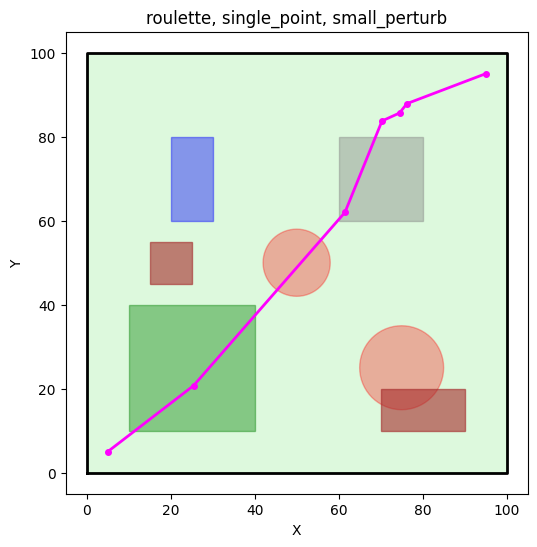

Best route (roulette, uniform, random): [(5, 5), (14.953906744091206, 12.214597057573041), (30.56430988070472, 20.310586907240292), (46.130370453008055, 39.46745388622769), (71.75666790888783, 78.30192338361681), (82.60709535280714, 86.7439254322315), (95, 95)]
Fitness: 129.02873039178934


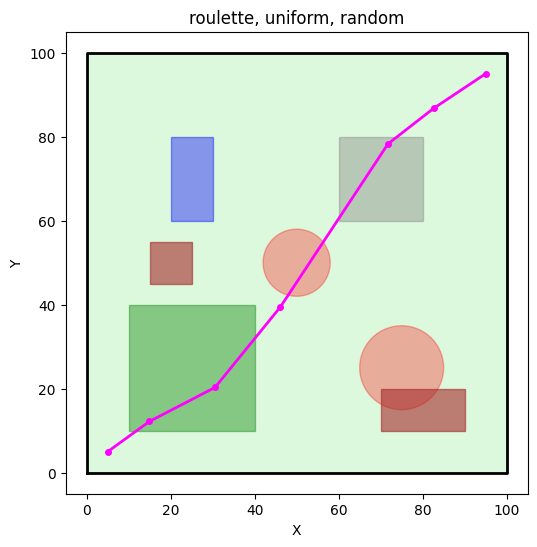

Best route (roulette, uniform, small_perturb): [(5, 5), (9.999318151139825, 14.196869292960951), (76.93955817195778, 14.31807877077934), (87.12896847446187, 25.492938724547862), (88.08934379809692, 72.34947073673547), (89.17739025672687, 77.62331106121475), (95, 95)]
Fitness: 162.90861745243075


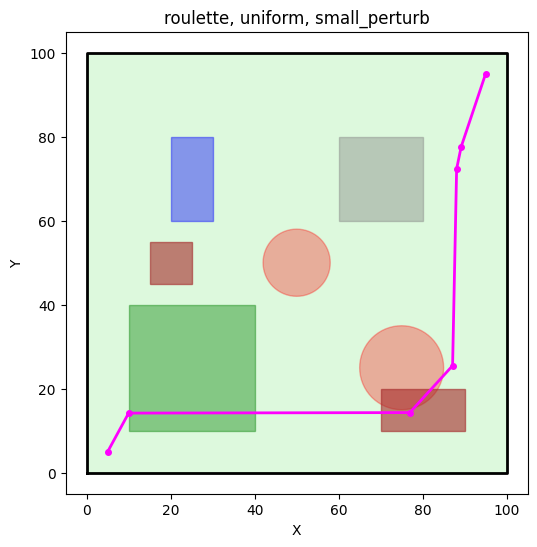

In [ ]:
test_ga_polygon_map()

The combination of roulette selection, single-point crossover, and small perturbation mutation is expected to perform better since roulette selection maintains diversity, single-point crossover keeps structured variations, and small perturbation mutation avoids drastic changes. However, this test primarily ensures functional correctness. The loss function will also be improved to account for dangerous zones rather than just route waypoints.

### Polygon‐based RL

In [ ]:
class DronePolygonEnv(gym.Env):
    """
    RL environment for local drone control in a polygon-based map.
    Observations: (x, y, heading, speed, cost)
    Actions: (delta_heading, delta_speed)
    """
    def __init__(self, map_env, start=(0, 0), boundary=None):
        super().__init__()
        self.map_env = map_env
        self.boundary = boundary

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32
        )

        self.action_space = spaces.Box(
            low=np.array([-0.5, -0.5], dtype=np.float32),
            high=np.array([0.5, 0.5], dtype=np.float32),
            dtype=np.float32
        )

        self.start = start
        self.state = None
        self.timestep = 0
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([self.start[0], self.start[1], 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        self.timestep = 0
        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        self.timestep += 1
        x, y, heading, speed, c, t = self.state

        d_heading, d_speed = action
        heading += d_heading
        speed = max(0, speed + d_speed)

        # Move
        dx = speed * np.cos(heading)
        dy = speed * np.sin(heading)
        x_new = x + dx
        y_new = y + dy

        cost = self.map_env.get_cost(x_new, y_new)
        reward = -cost  # negative cost => positive reward

        # Check boundary
        if self.boundary and not self.boundary.contains(Point(x_new, y_new)):
            # large penalty
            reward -= 10.0
            done = True
        else:
            done = False

        if self.timestep >= self.max_steps:
            done = True

        self.state = np.array([x_new, y_new, heading, speed, cost, self.timestep], dtype=np.float32)
        obs = self._get_obs()
        truncated = False

        return obs, reward, done, truncated, {}

    def _get_obs(self):
        return self.state

    def render(self):
        pass

In [ ]:
def test_rl_polygon_map():
    map_env, boundary = create_sample_polygon_map()

    env = DronePolygonEnv(map_env, start=(10,10), boundary=boundary)
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=1000000)

    obs, info = env.reset()
    done = False
    path = [ (obs[0], obs[1]) ]
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        path.append((obs[0], obs[1]))
        if done or truncated:
            break

    plot_polygon_map(
        map_env,
        boundary_polygon=boundary,
        path=path,
        title="RL Learned Path on Polygon Map")

Streaming output truncated to the last 5000 lines.
|    loss                 | 0.0179      |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.000275   |
|    std                  | 0.476       |
|    value_loss           | 0.0186      |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 49.4         |
| time/                   |              |
|    fps                  | 592          |
|    iterations           | 263          |
|    time_elapsed         | 909          |
|    total_timesteps      | 538624       |
| train/                  |              |
|    approx_kl            | 0.0115191005 |
|    clip_fraction        | 0.184        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 1            |
|    learning_rate        | 0.0003       |
|    loss

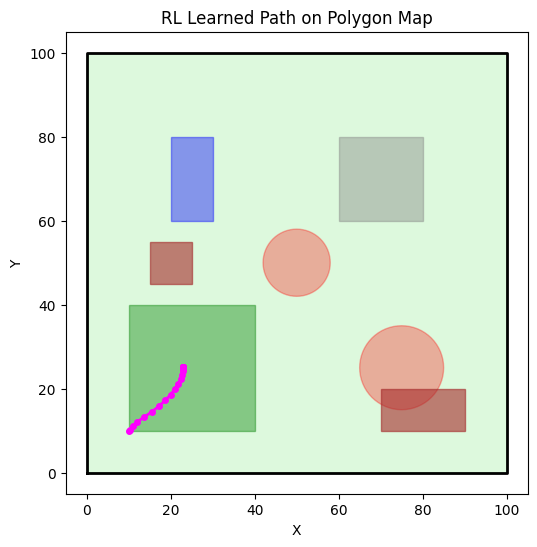

In [ ]:
test_rl_polygon_map()

Instead of simulating every small movement as a separate RL step, we can "skip" some frames so that a single RL action is repeated k times in the environment. Also Stable‐Baselines3 allows us to run multiple environments in parallel, so the agent collects experience from multiple copies of the environment simultaneously.  
By increasing time‐step granularity (frame skip) and vectorizing the environment, we can significantly speed up training while sacrificing a bit of fine‐grain control.

In [ ]:
class DronePolygonEnvFrameSkip(gym.Env):
    """
    A variant of the DronePolygonEnv that "skips" multiple frames each step.
    That means each "action" is repeated frame_skip times in the environment.
    """
    def __init__(self, map_env, start=(0, 0), boundary=None, frame_skip=5, max_steps=200):
        """
        frame_skip: number of sub-steps per RL action
        max_steps: maximum number of RL steps before termination
        """
        super().__init__()
        self.map_env = map_env
        self.boundary = boundary
        self.frame_skip = frame_skip
        self.max_steps = max_steps

        # observation space
        # [x, y, heading, speed, cost, time_step]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32
        )

        # define action space
        # [delta_heading, delta_speed], continuous
        self.action_space = spaces.Box(
            low=np.array([-0.5, -0.5], dtype=np.float32),
            high=np.array([0.5, 0.5], dtype=np.float32),
            dtype=np.float32
        )

        self.start = start
        self.state = None
        self.timestep = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # state = x, y, heading, speed, cost, time_step
        self.state = np.array([self.start[0], self.start[1], 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        self.timestep = 0
        return self._get_obs(), {}

    def step(self, action):
        """
        We apply "actio" for "frame_skip" sub-steps.
        We accumulate rewards (sum) and check for done.
        """
        total_reward = 0.0
        done = False
        truncated = False

        for _ in range(self.frame_skip):
            self.timestep += 1
            # Extract current state
            x, y, heading, speed, cost, t = self.state

            d_heading, d_speed = action
            heading += d_heading
            speed = max(0, speed + d_speed)

            # Move
            dx = speed * np.cos(heading)
            dy = speed * np.sin(heading)
            x_new = x + dx
            y_new = y + dy

            # Cost
            this_cost = self.map_env.get_cost(x_new, y_new)
            reward = -this_cost  # negative cost => positive reward

            # Boundary check
            if self.boundary and not self.boundary.contains(Point(x_new, y_new)):
                reward -= 10.0
                done = True

            total_reward += reward

            # Update state
            self.state = np.array([x_new, y_new, heading, speed, this_cost, self.timestep], dtype=np.float32)

            # Termination check
            if self.timestep >= self.max_steps:
                done = True
                truncated = True
                break

            if done:
                break

        return self._get_obs(), total_reward, done, truncated, {}

    def _get_obs(self):
        return self.state

    def render(self):
        pass

In [ ]:
def test_rl_polygon_map():
    map_env, boundary = create_sample_polygon_map()

    # Build parallel env with frame-skip
    n_envs = 24
    env_factories = []
    for i in range(n_envs):
        def make_env_i(i=i):
            start = (10 + i*3, 10)
            return DronePolygonEnvFrameSkip(map_env,
                                            start=start,
                                            boundary=boundary,
                                            frame_skip=5,
                                            max_steps=200)
        env_factories.append(make_env_i)

    vec_env = DummyVecEnv(env_factories)

    # Train with PPO
    model = PPO("MlpPolicy", vec_env, verbose=1,
                n_steps=2048,  # gather steps across parallel envs
                batch_size=512)
    model.learn(total_timesteps=5000000)

    # Test single rollout
    test_env = DronePolygonEnvFrameSkip(map_env, start=(10,10), boundary=boundary,
                                        frame_skip=5, max_steps=200)
    obs, info = test_env.reset()
    done = False
    path = [(obs[0], obs[1])]
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = test_env.step(action)
        path.append((obs[0], obs[1]))
        if done or truncated:
            break

    plot_polygon_map(
        map_env,
        boundary_polygon=boundary,
        path=path,
        title="Frame-Skip + Parallel RL Path"
    )

Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


------------------------------
| time/              |       |
|    fps             | 1482  |
|    iterations      | 1     |
|    time_elapsed    | 33    |
|    total_timesteps | 49152 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1381        |
|    iterations           | 2           |
|    time_elapsed         | 71          |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.005902685 |
|    clip_fraction        | 0.0582      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.00333     |
|    learning_rate        | 0.0003      |
|    loss                 | 247         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00504    |
|    std                  | 0.991       |
|    value_loss           | 511         |
---------------------------

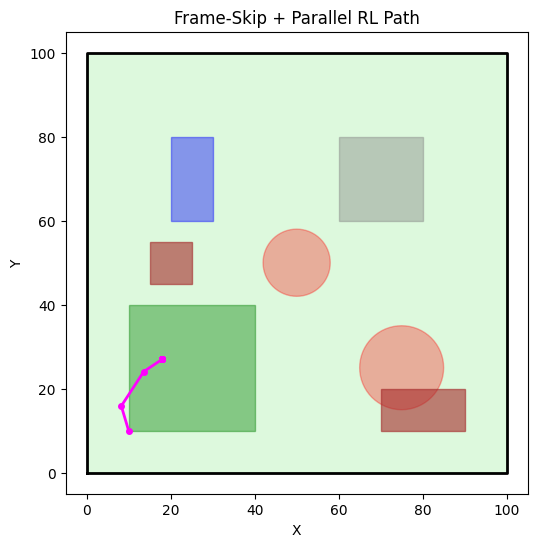

In [ ]:
test_rl_polygon_map()

We experimented with Reinforcement Learning (RL) in both a straightforward manner and with various optimizations—such as frame‐skipping and parallelized environments—to accelerate training. Despite these improvements, the RL approach still suffers from slow convergence on large problems. Therefore, our overall strategy primarily relies on the Genetic Algorithm for global route planning. We only employ RL in localized, high‐complexity segments (or "small complex areas"), where detailed decisions matter.

### GA&RL Dual Layer

**Single‐Drone Dual Approach**

We represent a "candidate solution" (individual) as a list of waypoints from the start to the goal.  Each waypoint is in the bounding region $[0..100]\times[0..100]$. The GA uses crossover and mutation to evolve these waypoints toward lower overall cost.

For each route segment (between consecutive waypoints), we run a discrete RL environment (with actions: turn left/right, go straight, speed up/down). The RL agent accumulates map costs (hazards, terrain penalties), thus "flying" the actual path to the next waypoint.  We track real flight cost (not just endpoint cost) to account for crossing hazards.

In the GA’s fitness function, we simulate the entire route with the RL policy, summing the cost from each segment’s environment rollout. The GA selects routes with lower total penalty (safer or shorter paths). The RL agent, trained on random sub‐goals, can handle various local segments.  

Outcome:
- The Genetic Algorithm refines a large‐scale waypoint plan.  
- The RL environment ensures each segment is navigated, penalizing hazards even in between waypoints.  
- Over multiple generations, routes with lower RL‐simulated cost survive, yielding a final "optimized" single‐drone path.




In [ ]:
class DroneDiscreteEnv(gym.Env):
    """
    Discrete-action environment for local flight from start to subgoal.
    5 actions:
      0 - turn left ~20°, then move
      1 - turn right ~20°, then move
      2 - go straight
      3 - speed up
      4 - slow down
    """
    def __init__(
        self,
        map_env,
        start=(0,0),
        subgoal=(50,50),
        boundary=None,
        max_steps=200,
        turn_radians=0.35,
        speed_delta=0.5,
        initial_heading=0.0,
        initial_speed=1.5,
        step_penalty=0.05,
        final_bonus=30.0,
        min_speed=1.0
    ):
        super().__init__()
        self.map_env         = map_env
        self.boundary        = boundary
        self.start           = start
        self.subgoal         = subgoal
        self.max_steps       = max_steps

        self.turn_radians    = turn_radians
        self.speed_delta     = speed_delta
        self.heading0        = initial_heading
        self.speed0          = initial_speed
        self.step_penalty    = step_penalty
        self.final_bonus     = final_bonus
        self.min_speed       = min_speed

        self.action_space = spaces.Discrete(5)
        # observation: [x, y, heading, speed, cost, dist_sg, step_idx]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)

        self.state    = None
        self.timestep = 0
        self.done     = False

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.timestep = 0
        self.done = False

        x, y = self.start
        cost = self.map_env.get_cost(x, y)
        dist_sg = np.hypot(self.subgoal[0]-x, self.subgoal[1]-y)
        self.state = np.array([x, y, self.heading0, self.speed0, cost, dist_sg, 0.0], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        if self.done:
            return self.state, 0.0, True, False, {}

        self.timestep += 1
        x, y, heading, speed, cost, dist_sg, idx = self.state

        # apply discrete action
        if action == 0:   # turn left
            heading += self.turn_radians
        elif action == 1: # turn right
            heading -= self.turn_radians
        elif action == 2: # go straight
            heading += 0.0
        elif action == 3: # speed up
            speed += self.speed_delta
        elif action == 4: # slow down
            speed = max(0, speed - self.speed_delta)

        # enforce min speed
        speed = max(speed, self.min_speed)

        # move
        dx = speed*np.cos(heading)
        dy = speed*np.sin(heading)
        x_new = x + dx
        y_new = y + dy

        new_cost = self.map_env.get_cost(x_new, y_new)
        new_dist_sg = np.hypot(self.subgoal[0]-x_new, self.subgoal[1]-y_new)
        progress = dist_sg - new_dist_sg

        # reward shaping
        reward = 0.0
        # negative cost => positive reward
        reward += -new_cost
        # progress
        reward += 0.3*progress
        # step penalty
        reward -= self.step_penalty

        done = False
        truncated = False

        # boundary
        if self.boundary and not self.boundary.contains(Point(x_new, y_new)):
            reward -= 10.0
            done = True

        # subgoal
        if new_dist_sg < 3.0:
            reward += self.final_bonus
            done = True

        # step limit
        if self.timestep >= self.max_steps:
            done = True
            truncated = True

        self.state = np.array([x_new, y_new, heading, speed, new_cost, new_dist_sg, float(self.timestep)], dtype=np.float32)
        self.done = done

        return self.state, reward, done, truncated, {}

In [ ]:
def sample_point_in_polygon(poly, max_tries=1000):
    minx, miny, maxx, maxy = poly.bounds
    for _ in range(max_tries):
        rx = random.uniform(minx, maxx)
        ry = random.uniform(miny, maxy)
        if poly.contains(Point(rx, ry)):
            return (rx, ry)
    return None

class RandomDroneDiscreteEnv(DroneDiscreteEnv):
    """
    Inherits from DroneDiscreteEnv, but overrides reset() to randomize the start/subgoal.
    """
    def __init__(self, map_env, boundary, max_steps=150):
        # parent init with dummy start/subgoal, then override in reset
        super().__init__(map_env, boundary=boundary, max_steps=max_steps)

        self.boundary = boundary

    def reset(self, seed=None, options=None):
        # random start/goal inside boundary
        s = sample_point_in_polygon(self.boundary)
        g = sample_point_in_polygon(self.boundary)
        if not s or not g:
            s = (5,5)
            g = (95,95)
        self.start   = s
        self.subgoal = g
        return super().reset(seed=seed, options=options)

In [ ]:
def train_discrete_rl(map_env, boundary, total_timesteps=200000):
    env = RandomDroneDiscreteEnv(map_env, boundary=boundary, max_steps=150)
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=total_timesteps)
    return model

In [ ]:
def euclidean_distance(a, b):
    return np.hypot(b[0] - a[0], b[1] - a[1])

class SynergyGeneticPlanner:
    """
    GA that evolves a route of waypoints. Fitness is computed by:
      - Summation of actual "map cost" encountered by RL policy
      - + a distance penalty for each segment
    """
    def __init__(
        self,
        map_env,
        boundary,
        rl_model,
        start,
        goal,
        population_size=15,
        num_waypoints=8
    ):
        self.map_env         = map_env
        self.boundary        = boundary
        self.rl_model        = rl_model
        self.start           = start
        self.goal            = goal
        self.population_size = population_size
        self.num_waypoints   = num_waypoints
        self.population      = []
        self._init_population()

    def _init_population(self):
        for _ in range(self.population_size):
            route = [self.start]
            for _ in range(self.num_waypoints):
                rx = random.uniform(0, 100)
                ry = random.uniform(0, 100)
                route.append((rx, ry))
            route.append(self.goal)
            self.population.append(route)

    def _simulate_segment(self, p1, p2):
        """
        Create a DroneDiscreteEnv from p1->p2, run RL policy, sum map cost each step.
        """
        env = DroneDiscreteEnv(self.map_env, start=p1, subgoal=p2, boundary=self.boundary, max_steps=150)
        obs, _ = env.reset()
        total_cost = 0.0
        done = False
        while not done:
            action, _ = self.rl_model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            x, y = obs[0], obs[1]
            step_cost = self.map_env.get_cost(x, y)
            total_cost += step_cost
            if done or truncated:
                break
        return total_cost

    def evaluate_fitness(self, route):
        """
        Sum the map cost from RL simulation + distance penalty.
        """
        total_cost = 0.0
        total_dist = 0.0
        for i in range(len(route)-1):
            seg_cost = self._simulate_segment(route[i], route[i+1])
            total_cost += seg_cost
            total_dist += euclidean_distance(route[i], route[i+1])

        final_fitness = total_cost + 0.2 * total_dist
        return final_fitness

    def selection(self, scored_pop):
        scored_pop.sort(key=lambda x: x[1])
        half = len(scored_pop)//2
        return [x[0] for x in scored_pop[:half]]

    def crossover(self, p1, p2):
        cut = random.randint(1, len(p1)-2)
        c1 = p1[:cut] + p2[cut:]
        c2 = p2[:cut] + p1[cut:]
        c1[0], c1[-1] = p1[0], p1[-1]
        c2[0], c2[-1] = p1[0], p1[-1]
        return c1, c2

    def mutate(self, route, rate=0.15):
        for i in range(1, len(route)-1):
            if random.random() < rate:
                dx = random.uniform(-5,5)
                dy = random.uniform(-5,5)
                nx = max(0, min(100, route[i][0]+dx))
                ny = max(0, min(100, route[i][1]+dy))
                route[i] = (nx, ny)
        return route

    def evolve(self, generations=5):
        for g in range(generations):
            scored_pop = []
            for ind in self.population:
                cost_val = self.evaluate_fitness(ind)
                scored_pop.append((ind, cost_val))

            new_pop = self.selection(scored_pop)
            offspring = []
            while len(offspring) < self.population_size:
                p1, p2 = random.sample(new_pop, 2)
                c1, c2 = self.crossover(p1, p2)
                c1 = self.mutate(c1)
                c2 = self.mutate(c2)
                offspring.extend([c1, c2])
            self.population = offspring

        # final best
        scored_pop = []
        for ind in self.population:
            cost_val = self.evaluate_fitness(ind)
            scored_pop.append((ind, cost_val))
        best_ind, best_val = min(scored_pop, key=lambda x: x[1])
        return best_ind, best_val

In [ ]:
def run_improved_synergy_demo():
    map_env, boundary = create_sample_polygon_map()

    rl_model = train_discrete_rl(map_env, boundary, total_timesteps=10000)

    synergy_ga = SynergyGeneticPlanner(
        map_env=map_env,
        boundary=boundary,
        rl_model=rl_model,
        start=(5,5),
        goal=(90,90),
        population_size=15,
        num_waypoints=8
    )
    best_route, best_score = synergy_ga.evolve(generations=5)
    print("Best synergy route cost:", best_score)
    print("Waypoints:", best_route)

    plot_polygon_map(map_env, boundary_polygon=boundary, path=best_route,
                     title="Single GA")

    final_path = []
    for i in range(len(best_route)-1):
        seg_env = DroneDiscreteEnv(map_env, start=best_route[i], subgoal=best_route[i+1],
                                   boundary=boundary, max_steps=150)
        obs, _ = seg_env.reset()
        seg_points = [best_route[i]]
        done = False

        while not done:
            action, _ = rl_model.predict(obs, deterministic=True)
            obs, rew, done, truncated, info = seg_env.step(action)
            seg_points.append((obs[0], obs[1]))
            if done or truncated:
                break

        final_path.extend(seg_points[:-1])
    final_path.append(best_route[-1])

    plot_polygon_map(map_env, boundary_polygon=boundary, path=final_path,
                     title="Synergy GA + Discrete RL")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.8     |
|    ep_rew_mean     | -21.8    |
| time/              |          |
|    fps             | 771      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 33.3        |
|    ep_rew_mean          | -22.7       |
| time/                   |             |
|    fps                  | 604         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010832221 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss   

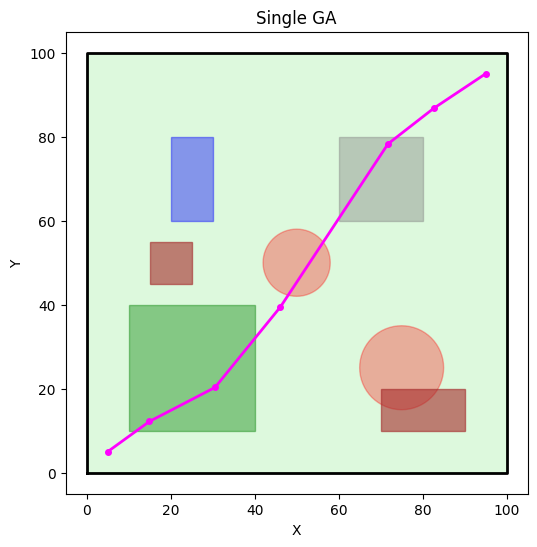

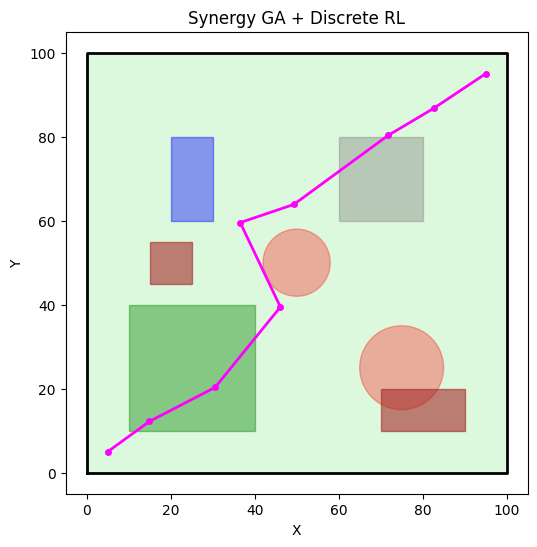

In [ ]:
run_improved_synergy_demo()

**Multiple‐Drone Extension**

Each GA individual now encodes one route per drone. For $N$ drones, the individual is a list of $N$ routes, each route being a list of waypoints.  Start and goal positions differ for each drone, but the same GA processes them in parallel.

For each drone’s route, we split into segments and run the same RL policy (or separate ones). We accumulate map cost from each drone’s flight. If needed, you can also include inter‐drone constraints (collision avoidance).

The GA’s selection/crossover/mutation works similarly, but each parent/child is a multi‐drone set of routes. The GA tries to minimize the sum of all drones’ RL‐simulated costs, improving coordination across multiple vehicles.

In [ ]:
class MultiDroneSynergyGA:
    """
    Each individual is a list of routes, one route per drone.
    routes[i] = a list of (x,y) points from start_i to goal_i
    We'll evaluate by simulating each route with the RL policy, summing the cost.
    """
    def __init__(
        self,
        map_env,
        boundary,
        rl_model,
        start_points,
        goal_points,
        num_waypoints=5,
        population_size=10
    ):
        self.map_env        = map_env
        self.boundary       = boundary
        self.rl_model       = rl_model
        self.start_points   = start_points
        self.goal_points    = goal_points
        self.num_drones     = len(start_points)
        self.num_waypoints  = num_waypoints
        self.population_size= population_size
        self.population     = []
        self._init_population()

    def _init_population(self):
        """For each drone, we generate a route with random waypoints. Then store them as one 'individual'."""
        for _ in range(self.population_size):
            individual = []
            for d in range(self.num_drones):
                route = [self.start_points[d]]
                for _ in range(self.num_waypoints):
                    rx = random.uniform(0, 100)
                    ry = random.uniform(0, 100)
                    route.append((rx, ry))
                route.append(self.goal_points[d])
                individual.append(route)
            self.population.append(individual)

    def _simulate_segment(self, p1, p2):
        """Simulate one segment p1->p2 with the RL policy, summing map cost each step."""
        env = DroneDiscreteEnv(
            self.map_env,
            start=p1, subgoal=p2,
            boundary=self.boundary,
            max_steps=150
        )
        obs, _ = env.reset()
        total_cost = 0.0
        done = False
        while not done:
            action, _ = self.rl_model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            x, y = obs[0], obs[1]
            step_cost = self.map_env.get_cost(x, y)
            total_cost += step_cost
            if done or truncated:
                break
        return total_cost

    def evaluate_fitness(self, individual):
        """
        'individual' = [ route_for_drone1, route_for_drone2, ..., route_for_droneN ]
        Each route is a list of points. We sum the cost from RL sim.
        """
        total_cost = 0.0
        for d, route in enumerate(individual):
            for i in range(len(route)-1):
                seg_cost = self._simulate_segment(route[i], route[i+1])
                total_cost += seg_cost

            dist_sum = 0.0
            for i in range(len(route)-1):
                dist_sum += euclidean_distance(route[i], route[i+1])
            total_cost += 0.2*dist_sum

        return total_cost

    def selection(self):
        """Evaluate all, keep top half by ascending cost."""
        scored = [(ind, self.evaluate_fitness(ind)) for ind in self.population]
        scored.sort(key=lambda x: x[1])  # ascending cost
        half = len(scored)//2
        survivors = [x[0] for x in scored[:half]]
        return survivors

    def crossover(self, parent1, parent2):
        """
        parent1, parent2 are lists of routes (one route per drone).
        We'll do single-point crossover on each drone's route individually.
        """
        child1, child2 = [], []
        for r1, r2 in zip(parent1, parent2):
            cut = random.randint(1, len(r1)-2)
            c1 = r1[:cut] + r2[cut:]
            c2 = r2[:cut] + r1[cut:]
            # fix start/end
            c1[0], c1[-1] = r1[0], r1[-1]
            c2[0], c2[-1] = r1[0], r1[-1]
            child1.append(c1)
            child2.append(c2)
        return child1, child2

    def mutate(self, individual, rate=0.1):
        """
        For each drone route, random perturb the intermediate waypoints.
        """
        for route in individual:
            for i in range(1, len(route)-1):
                if random.random() < rate:
                    dx = random.uniform(-5,5)
                    dy = random.uniform(-5,5)
                    nx = max(0, min(100, route[i][0]+dx))
                    ny = max(0, min(100, route[i][1]+dy))
                    route[i] = (nx, ny)
        return individual

    def evolve(self, generations=5, mutation_rate=0.1):
        for g in range(generations):
            survivors = self.selection()
            new_pop = []
            while len(new_pop) < self.population_size:
                p1, p2 = random.sample(survivors, 2)
                c1, c2 = self.crossover(p1, p2)
                c1 = self.mutate(c1, mutation_rate)
                c2 = self.mutate(c2, mutation_rate)
                new_pop.extend([c1, c2])
            self.population = new_pop

        # final best
        scored = [(ind, self.evaluate_fitness(ind)) for ind in self.population]
        best_ind, best_val = min(scored, key=lambda x: x[1])
        return best_ind, best_val

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_polygon_map(
    map_env,
    boundary_polygon=None,
    paths=None,
    title="Polygon Map Visualization"
):
    """
    Visualize terrain polygons, hazard circles, building polygons,
    plus an optional path (a list of (x, y) points).
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot bounding polygon if provided
    if boundary_polygon:
        xs, ys = boundary_polygon.exterior.xy
        ax.plot(xs, ys, color='black', linewidth=2)
        ax.fill(xs, ys, color='lightgreen', alpha=0.3)

    # Color definitions
    terrain_colors = {
        "forest": "green",
        "mountain": "gray",
        "water": "blue",
    }

    # Plot terrain polygons
    for ttype, plist in map_env.terrain_polygons.items():
        color = terrain_colors.get(ttype, "lightgreen")  # default for grass
        for poly in plist:
            xcoords, ycoords = poly.exterior.xy
            ax.fill(xcoords, ycoords, color=color, alpha=0.4, label=ttype)

    # Plot hazard circles in red
    for h in map_env.hazard_circles:
        hx, hy = h.exterior.xy
        ax.fill(hx, hy, color="red", alpha=0.3)

    # Plot buildings in dark brown
    for bpoly in map_env.building_polygons:
        bx, by = bpoly.exterior.xy
        ax.fill(bx, by, color="brown", alpha=0.6)

    # Plot path if provided
    if paths:
        for path in paths:
            xs = [p[0] for p in path]
            ys = [p[1] for p in path]
            ax.plot(xs, ys, color='magenta', marker='o', linewidth=2, markersize=4)

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', 'box')
    plt.show()

In [ ]:
def run_multi_drone_demo():
    map_env, boundary = create_sample_polygon_map()

    model = train_discrete_rl(map_env, boundary, total_timesteps=10000)

    start_points = [(5,5), (5,95)]
    goal_points  = [(95,5), (95,95)]

    # 4) GA synergy
    multi_ga = MultiDroneSynergyGA(
        map_env=map_env,
        boundary=boundary,
        rl_model=model,
        start_points=start_points,
        goal_points=goal_points,
        num_waypoints=4,
        population_size=8
    )
    best_ind, best_val = multi_ga.evolve(generations=5, mutation_rate=0.1)
    print("Multi-Drone GA best cost:", best_val)

    all_paths = []
    for d, route in enumerate(best_ind):
        final_path = []
        for seg_i in range(len(route)-1):
            seg_env = DroneDiscreteEnv(map_env, start=route[seg_i], subgoal=route[seg_i+1],
                                       boundary=boundary, max_steps=150)
            obs, _ = seg_env.reset()
            seg_points = [route[seg_i]]
            done = False
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, rew, done, truncated, info = seg_env.step(action)
                seg_points.append((obs[0], obs[1]))
                if done or truncated:
                    break
            final_path.extend(seg_points[:-1])
        final_path.append(route[-1])
        all_paths.append(final_path)

    plot_polygon_map(map_env, boundary=boundary, paths=all_paths,
                     title="Multi-Drone GA+RL synergy")

Multi-Drone GA best cost: 154.4763081710483


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


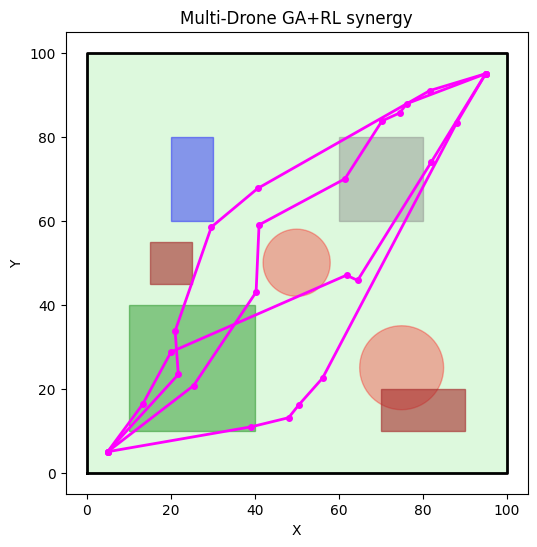

In [ ]:
run_multi_drone_demo()

# Real Data Demo

We begin by loading a CSV containing polygon geometries (in WKT format) and a terrain label ("wood", "water", "industrial"). Each row’s WKT is parsed into a Shapely Polygon or MultiPolygo`. We organize these polygons by terrain type, build a unified bounding region from their combined extents, and scatter a predefined number of circular hazard zones near the bounding region’s center for added complexity.

Once the environment is set, we train a discrete‐action RL policy on random local sub‐goals, enabling it to handle varied short‐range flights. Finally, a Genetic Algorithm orchestrates multi‐drone route planning at a global scale: each GA individual encodes full routes for multiple drones, and we simulate each segment using the RL policy to accumulate real environment costs.

### Dataset Overview

In [ ]:
# Load the dataset
file_path = "/content/dataset-not-full.csv"
df = pd.read_csv(file_path)

# Display dataset structure
dataset_info = {
    "Columns": df.columns.tolist(),
    "Total Rows": len(df),
    "Missing Values": df.isnull().sum().to_dict(),
    "Unique Labels per Column": {col: df[col].nunique() for col in df.columns if df[col].dtype == 'object'}
}

# Extract unique values for categorical columns
unique_values = {col: df[col].dropna().unique().tolist() for col in df.columns if df[col].dtype == 'object'}

# Show dataset overview
print("Dataset Overview:")
print(df.head())

# Print dataset structure
print("\nDataset Structure:")
for key, value in dataset_info.items():
    print(f"{key}: {value}")

# Print unique values per categorical column
print("\nUnique Labels Per Column:")
for col, values in unique_values.items():
    print(f"{col}: {values[:10]}")  # Show only first 10 unique values


Dataset Overview:
                                            geometry  \
0  POLYGON ((36.0655553 51.6632804, 36.0656733 51...   
1  POLYGON ((36.1168516 51.6893867, 36.1169754 51...   
2  POLYGON ((36.2233546 51.7047013, 36.2229827 51...   
3  POLYGON ((36.2336523 51.6924196, 36.2337656 51...   
4  POLYGON ((36.2574562 51.691009, 36.257487 51.6...   

                                        bounding_box natural building  
0  POLYGON ((36.0646404 51.6568149, 36.0857448 51...    wood      NaN  
1  POLYGON ((36.1137957 51.6871137, 36.1219311 51...    wood      NaN  
2  POLYGON ((36.2216628 51.7021693, 36.2277822 51...    wood      NaN  
3  POLYGON ((36.2336523 51.6899532, 36.2575137 51...   water      NaN  
4  POLYGON ((36.2574562 51.6813797, 36.2799029 51...   water      NaN  

Dataset Structure:
Columns: ['geometry', 'bounding_box', 'natural', 'building']
Total Rows: 2047
Missing Values: {'geometry': 0, 'bounding_box': 0, 'natural': 300, 'building': 1747}
Unique Labels per Column: {'ge

In [ ]:
# Create a new dataset with polygons and a unified terrain type

# Fill 'terrain' column by combining 'natural' and 'building' columns
df["terrain"] = df["natural"].combine_first(df["building"])

# Select only necessary columns: geometry and terrain type
df_filtered = df[["geometry", "terrain"]].dropna()

# Save the processed dataset
processed_file_path = "/content/processed_dataset.csv"
df_filtered.to_csv(processed_file_path, index=False)

# Print unique values of 'terrain' column
unique_terrain_values = df_filtered["terrain"].unique()
print("Unique terrain Types:", unique_terrain_values)

df_filtered

Unique terrain types: ['wood' 'water' 'industrial']


,geometry,terrain
0,"POLYGON ((36.0655553 51.6632804, 36.0656733 51...",wood
1,"POLYGON ((36.1168516 51.6893867, 36.1169754 51...",wood
2,"POLYGON ((36.2233546 51.7047013, 36.2229827 51...",wood
3,"POLYGON ((36.2336523 51.6924196, 36.2337656 51...",water
4,"POLYGON ((36.2574562 51.691009, 36.257487 51.6...",water
...,...,...
2042,"POLYGON ((36.1462196 51.7021668, 36.1461636 51...",wood
2043,"POLYGON ((36.1461093 51.7019752, 36.1460875 51...",wood
2044,"POLYGON ((36.1312196 51.7683461, 36.1311807 51...",water
2045,"POLYGON ((36.1622882 51.7079523, 36.1621735 51...",wood


### Polygon Map Environment

We have polygon data describing different terrain types—like wood, water, and industrial — each with its own "cost" or penalty for flying overhead. We also scatter some hazard circles in the map to represent dangerous areas. Our PolygonMapEnvironment class compiles all this information so that if we ask it about any location $(x, y)$, it can tell us how risky or beneficial that spot is.

How it works:  
- We load a CSV containing the terrain polygons in WKT format along with a label stating whether each polygon is "wood", "water", or "industrial".  
- We build a unified boundary around them and place hazard circles (like red zones) in the central portion of the map to add complexity.  
- When we need to evaluate a point, the environment checks which polygon(s) the point might be in. Then it sees if the point is inside any hazard circle (much more costly). It sums up all those penalties and returns a single cost value.

This environment acts as the "world" we’re optimizing paths for. If a path crosses an industrial site or hazard circle, that leads to a higher penalty (worse solution). Flying over wood might be cheaper or even slightly beneficial.

In [ ]:
class PolygonMapEnvironment:
    """
    Holds polygons for terrain types (wood, water, industrial)
    plus multiple hazard circles. get_cost(x,y) => penalty or reward.
    """
    def __init__(self, terrain_polygons, hazard_circles=None):
        self.terrain_polygons = terrain_polygons
        self.hazard_circles = hazard_circles if hazard_circles else []
        self.hazard_union = unary_union(self.hazard_circles) if self.hazard_circles else None

    def get_cost(self, x, y):
        pt = Point(x, y)
        cost = 0.0

        ttype = self._find_terrain_type(pt)
        if ttype == 'wood':
            cost -= 0.3
        elif ttype == 'water':
            cost += 1.0
        elif ttype == 'industrial':
            cost += 2.0

        if self.hazard_union and self.hazard_union.contains(pt):
            cost += 5.0

        return cost

    def _find_terrain_type(self, point):
        """Return 'wood','water','industrial', or None; handle Polygon & MultiPolygon."""
        for ttype, poly_list in self.terrain_polygons.items():
            for geom in poly_list:
                if geom.geom_type == 'Polygon':
                    if geom.contains(point):
                        return ttype
                elif geom.geom_type == 'MultiPolygon':
                    for subpoly in geom.geoms:
                        if subpoly.contains(point):
                            return ttype
        return None

In [115]:
def random_points_in_center_of_bounds(bounding_poly, n=20):
    """
    Generate ~n random points in a smaller bounding box around the bounding_poly's centroid.
    """
    cx, cy = bounding_poly.centroid.x, bounding_poly.centroid.y
    minx, miny, maxx, maxy = bounding_poly.bounds
    w = maxx - minx
    h = maxy - miny

    half_scale = 0.5
    local_minx = cx - (w * half_scale / 2)
    local_maxx = cx + (w * half_scale / 2)
    local_miny = cy - (h * half_scale / 2)
    local_maxy = cy + (h * half_scale / 2)

    points = []
    for _ in range(n):
        rx = random.uniform(local_minx, local_maxx)
        ry = random.uniform(local_miny, local_maxy)
        points.append((rx, ry))
    return points

def create_mapenv_from_csv(
    csv_path,
    geometry_col='geometry',
    terrain_col='terrain',
    known_terrains=('wood','water','industrial'),
    n_hazards=20,
    hazard_radius_min=0.002,
    hazard_radius_max=0.006
):
    """
    Load CSV, parse polygons, group them by terrain, union => bounding box.
    Return map_env, bounding_poly, df.
    """
    df = pd.read_csv(csv_path)
    df['geometry_parsed'] = df[geometry_col].apply(shapely.wkt.loads)

    # group polygons
    terrain_dict = {t: [] for t in known_terrains}
    for _, row in df.iterrows():
        ttype = row[terrain_col]
        geom = row['geometry_parsed']
        if ttype in terrain_dict:
            terrain_dict[ttype].append(geom)

    # union => bounding poly
    all_geoms = []
    for glist in terrain_dict.values():
        all_geoms.extend(glist)
    union_geom = unary_union(all_geoms)
    if not union_geom.is_empty:
        minx, miny, maxx, maxy = union_geom.bounds
    else:
        # fallback bounding box
        minx, miny, maxx, maxy = 36.0, 51.65, 36.3, 51.85
    bounding_poly = Polygon([(minx, miny),(maxx, miny),(maxx, maxy),(minx, maxy)])

    # random hazard circles in center region
    center_points = random_points_in_center_of_bounds(bounding_poly, n=n_hazards)
    hazard_polys = []
    for (cx, cy) in center_points:
        r = random.uniform(hazard_radius_min, hazard_radius_max)
        circ = Point(cx, cy).buffer(r)
        hazard_polys.append(circ)

    # build environment
    map_env = PolygonMapEnvironment(terrain_dict, hazard_polys)
    return map_env, bounding_poly, df

def plot_csv_map_many_paths_with_arrows(
    map_env, bounding_polygon, df,
    geometry_col='geometry_parsed',
    terrain_col='terrain',
    path_groups=None,
    group_labels=None
):
    fig, ax = plt.subplots(figsize=(20,20))

    # bounding polygon
    bx, by = bounding_polygon.exterior.xy
    ax.plot(bx, by, color='black', linewidth=2)

    # terrain colors
    terrain_colors = {
        'wood': 'green',
        'water': 'blue',
        'industrial': 'brown'
    }

    # draw polygons
    for ttype, color in terrain_colors.items():
        subset = df[df[terrain_col] == ttype]
        for _, row in subset.iterrows():
            geom = row[geometry_col]
            if geom.geom_type == 'Polygon':
                xcoords, ycoords = geom.exterior.xy
                ax.fill(xcoords, ycoords, color=color, alpha=0.4)
            elif geom.geom_type == 'MultiPolygon':
                for subpoly in geom.geoms:
                    xcoords, ycoords = subpoly.exterior.xy
                    ax.fill(xcoords, ycoords, color=color, alpha=0.4)

    # hazards => red
    for hc in map_env.hazard_circles:
        hx, hy = hc.exterior.xy
        ax.fill(hx, hy, color='red', alpha=0.3)

    # multiple path groups with arrowed lines
    if path_groups:
        colors = ['darkorange','orangered','blueviolet','cyan','purple','yellow','lime']
        for i, path in enumerate(path_groups):
            c = colors[i % len(colors)]
            label_str = f"Group {i+1}"
            if group_labels and i < len(group_labels):
                label_str = group_labels[i]

            for seg_idx in range(len(path)-1):
                (x1, y1) = path[seg_idx]
                (x2, y2) = path[seg_idx+1]
                arrow = FancyArrowPatch(
                    (x1, y1), (x2, y2),
                    arrowstyle='-|>',
                    color=c,
                    lw=2,
                    mutation_scale=15
                )
                ax.add_patch(arrow)
            ax.plot([],[], color=c, lw=2, label=label_str)

        ax.legend()

    ax.set_title("CSV-based Polygon Map")
    ax.set_aspect('equal', 'box')
    plt.show()

def plot_map_and_paths(
    map_env, bounding_polygon, df,
    geometry_col='geometry_parsed',
    terrain_col='terrain',
    path_groups=None,  # e.g. [ [(x1,y1)...], [(x2,y2)...] ]
    group_labels=None
):
    fig, ax = plt.subplots(figsize=(20,20))

    # bounding polygon
    bx, by = bounding_polygon.exterior.xy
    ax.plot(bx, by, color='black', linewidth=2)

    terrain_colors = {'wood':'green','water':'blue','industrial':'brown'}

    # fill polygons
    for ttype, c in terrain_colors.items():
        subset = df[df[terrain_col] == ttype]
        for _, row in subset.iterrows():
            geom = row[geometry_col]
            if geom.geom_type == 'Polygon':
                xcoords, ycoords = geom.exterior.xy
                ax.fill(xcoords, ycoords, color=c, alpha=0.4)
            elif geom.geom_type == 'MultiPolygon':
                for subpoly in geom.geoms:
                    xx, yy = subpoly.exterior.xy
                    ax.fill(xx, yy, color=c, alpha=0.4)

    # hazards => red
    for hc in map_env.hazard_circles:
        hx, hy = hc.exterior.xy
        ax.fill(hx, hy, color='red', alpha=0.3)

    # multiple path groups with arrowed lines
    if path_groups:
        color_list = ['darkorange','orangered','blueviolet','cyan','purple','yellow','lime']
        for i, path in enumerate(path_groups):
            color = color_list[i % len(color_list)]
            label_str = f"Group {i+1}"
            if group_labels and i < len(group_labels):
                label_str = group_labels[i]

            for seg_idx in range(len(path)-1):
                x1,y1 = path[seg_idx]
                x2,y2 = path[seg_idx+1]
                arrow = FancyArrowPatch(
                    (x1,y1),(x2,y2),
                    arrowstyle='-|>',
                    color=color,
                    lw=2,
                    mutation_scale=15
                )
                ax.add_patch(arrow)

            ax.plot([],[], color=color, lw=2, label=label_str)

        ax.legend()

    ax.set_title("Map with 2 Groups of Drones (Arrowed Paths)")
    ax.set_aspect('equal', 'box')
    plt.show()

In [113]:
def demo():
    # create environment from your CSV
    map_env, bounding_poly, df = create_mapenv_from_csv(
        csv_path="/content/processed_dataset.csv",
        geometry_col="geometry",
        terrain_col="terrain",
        known_terrains=('wood','water','industrial'),
        n_hazards=20,
        hazard_radius_min=0.002,
        hazard_radius_max=0.006
    )

    # define 2 path groups for example
    path_group1 = [(36.05,51.66),(36.065,51.665),(36.08,51.667)]
    path_group2 = [(36.06,51.66),(36.065,51.662),(36.075,51.666),(36.085,51.668)]
    path_groups = [path_group1, path_group2]
    labels = ["Group A", "Group B"]

    # plot with arrowed lines
    plot_csv_map_many_paths_with_arrows(
        map_env, bounding_poly, df,
        geometry_col='geometry_parsed',
        terrain_col='terrain',
        path_groups=path_groups,
        group_labels=labels
    )

    # check cost
    cost_test = map_env.get_cost(36.065, 51.663)
    print("Cost at (36.065, 51.663):", cost_test)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


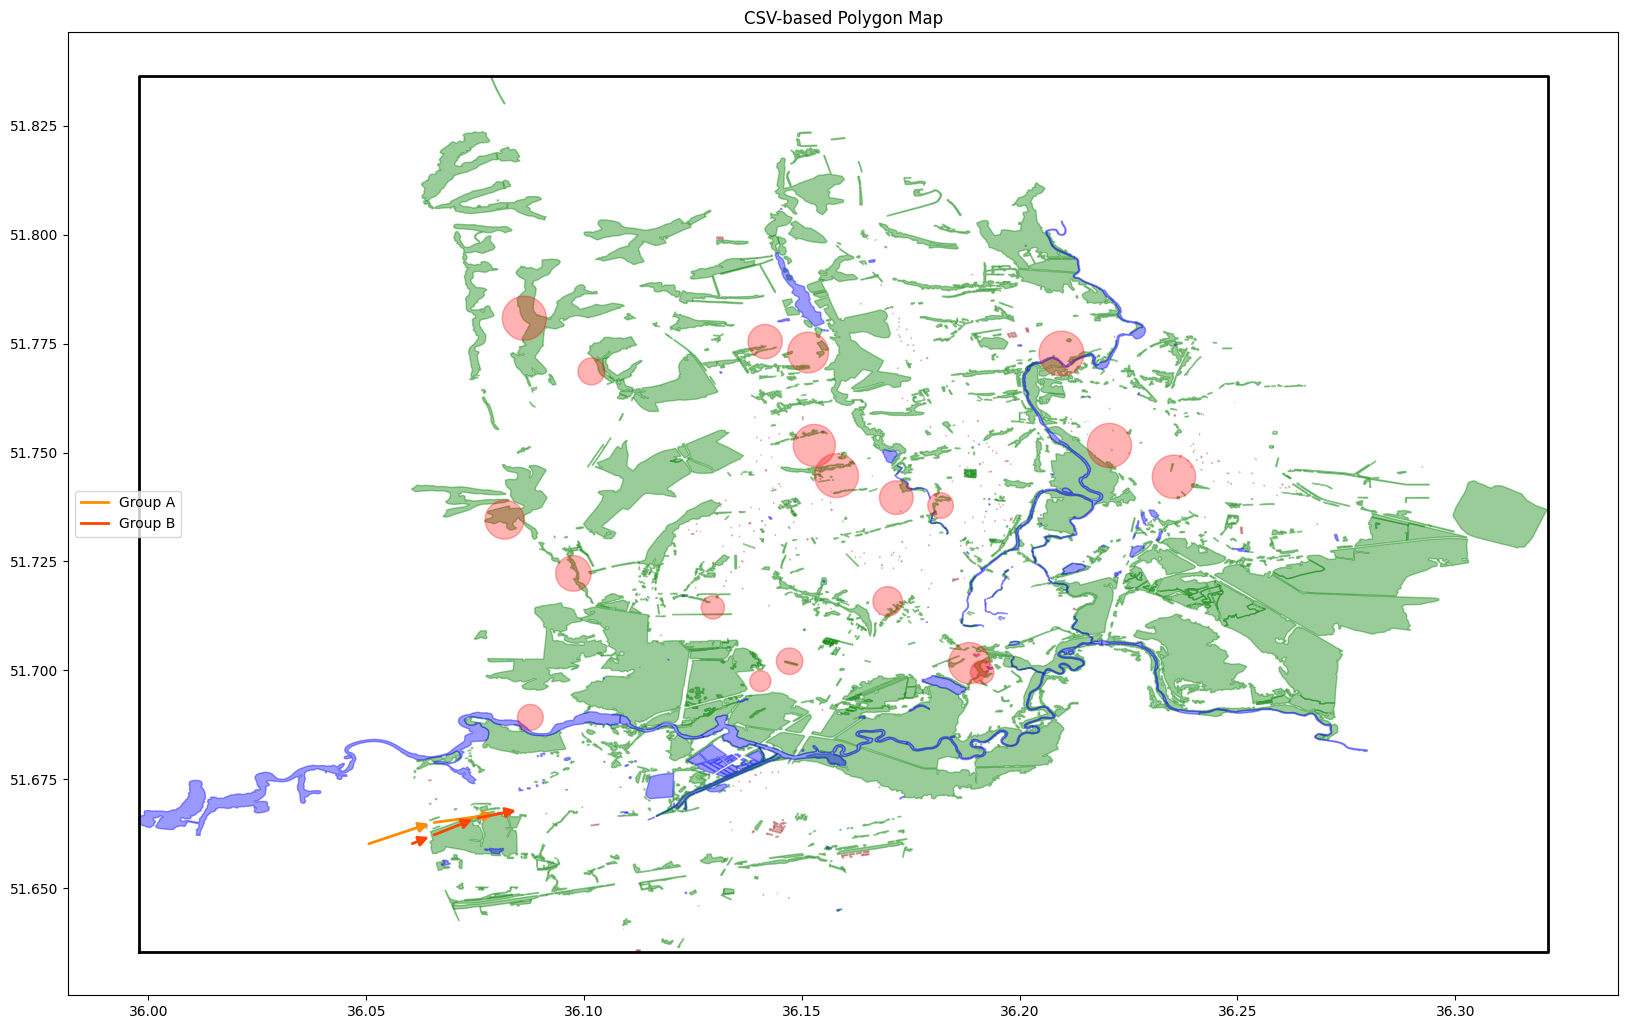

Cost at (36.065, 51.663): -0.3


In [114]:
demo()

### RL Environment and Training

We break down the drone’s flight into short "local" segments. The drone uses a discrete set of actions (like turning left, going straight, speeding up, etc.) to travel from one waypoint to the next. We train a Reinforcement Learning policy so it learns how to handle unexpected local conditions, avoid hazards, and minimize cost on these small hops.

Each step’s reward is based on terrain cost (from our PolygonMapEnvironment) plus some shaping terms, like a bonus for moving closer to the waypoint and a penalty for taking too many steps.  We randomize the local start and sub‐goal in training, so the policy sees a variety of short segments. Then we use PPO to train until the drone can reliably navigate short distances with minimal cost.

Even if we figure out a large‐scale route, local hazards and micro decisions matter. The RL policy handles day‐to‐day movement at a finer granularity, letting us incorporate real terrain penalties in each short step.

In [ ]:
class DroneDiscreteEnv(gym.Env):
    def __init__(self, map_env, start=(0,0), subgoal=(1,1), boundary=None, max_steps=200):
        super().__init__()
        self.map_env = map_env
        self.boundary = boundary
        self.start = start
        self.subgoal = subgoal
        self.max_steps = max_steps

        self.turn_radians = 0.35
        self.speed_delta = 0.5
        self.min_speed = 1.0
        self.step_penalty = 0.05
        self.final_bonus = 30.0

        # obs = [x, y, heading, speed, cost, dist_subgoal, step_idx]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32
        )

        self.action_space = spaces.Discrete(5)
        self.state = None
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.timestep = 0

        # start in (start.x, start.y), heading=0, speed=1.5
        x, y = self.start
        cost_now = self.map_env.get_cost(x, y)
        dist_sg = np.hypot(self.subgoal[0]-x, self.subgoal[1]-y)
        self.state = np.array([x, y, 0.0, 1.5, cost_now, dist_sg, 0.0], dtype=np.float32)
        self.done = False
        return self.state, {}

    def step(self, action):
        if self.done:
            return self.state, 0.0, True, False, {}

        self.timestep += 1
        x, y, heading, speed, cost, dist_sg, step_idx = self.state

        # Apply discrete action
        if action == 0:   # turn left
            heading += self.turn_radians
        elif action == 1: # turn right
            heading -= self.turn_radians
        elif action == 2: # go straight
            heading += 0.0
        elif action == 3: # speed up
            speed += self.speed_delta
        elif action == 4: # slow down
            speed = max(0, speed - self.speed_delta)

        # enforce min speed
        speed = max(self.min_speed, speed)

        # move
        dx = speed * np.cos(heading)
        dy = speed * np.sin(heading)
        x_new = x + dx
        y_new = y + dy

        # map cost
        new_cost = self.map_env.get_cost(x_new, y_new)
        new_dist_sg = np.hypot(self.subgoal[0]-x_new, self.subgoal[1]-y_new)

        progress = dist_sg - new_dist_sg

        # shaping reward
        reward = 0.0
        # negative cost => positive reward
        reward += -new_cost
        # progress
        reward += 0.3 * progress
        # step penalty
        reward -= self.step_penalty

        done = False
        truncated = False

        # check boundary
        if self.boundary and not self.boundary.contains(Point(x_new, y_new)):
            reward -= 10.0
            done = True

        # check sub-goal
        if new_dist_sg < 3.0:
            reward += self.final_bonus
            done = True

        # step limit
        if self.timestep >= self.max_steps:
            done = True
            truncated = True

        self.state = np.array([
            x_new, y_new, heading, speed,
            new_cost, new_dist_sg, float(self.timestep)
        ], dtype=np.float32)
        self.done = done

        return self.state, reward, done, truncated, {}

In [ ]:
def make_random_env(map_env, boundary, max_steps=150):
    """
    Returns a specialized environment that picks random start/subgoal each reset,
    so the PPO policy generalizes to different local segments.
    """
    class RandomLocalDroneEnv(DroneDiscreteEnv):
        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            # random subgoal in bounding box
            minx, miny, maxx, maxy = boundary.bounds
            gx = random.uniform(minx, maxx)
            gy = random.uniform(miny, maxy)
            # We'll place the start near that subgoal but offset
            sx = gx - 0.01
            sy = gy - 0.01
            self.start = (sx, sy)
            self.subgoal = (gx, gy)
            return super(RandomLocalDroneEnv, self).reset(seed=seed, options=options)

    return RandomLocalDroneEnv(map_env, boundary=boundary, max_steps=max_steps)

def train_rl_for_local_control(map_env, bounding_poly, timesteps=50000):
    """
    Create a random-subgoal environment, train PPO for 'timesteps'.
    Return the trained model.
    """
    from stable_baselines3 import PPO

    env = make_random_env(map_env, bounding_poly, max_steps=150)
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=timesteps)
    return model

### Multi‐Drone GA Synergy

The GA tries to reduce the total penalty for all drones (like avoiding big hazards, not crossing water unnecessarily, etc.). We define a GA "individual" that holds every drone’s route—waypoints from its start to its goal. Each route is split into segments, and for each segment, we simulate the RL policy and sum up the real costs from the map environment.  

The GA ranks solutions (lowest total cost is better), picks and recombines (crossover) the better ones, and mutates waypoints a bit to explore new possibilities. After several generations, we (hopefully) end up with a multi‐drone plan that balances traveling through cheaper terrain and avoiding hazards, while letting the RL handle local fine‐tuning.

We can’t rely on RL alone for large‐scale route planning—it’s slow to converge on a giant problem and might not see the whole map, as you can see in the previous parts of this research. Likewise, a purely GA approach might only guess about local movement. By fusing them (GA for the big picture, RL for local movement) we get a more optimal and realistic multi‐drone strategy.

In [ ]:
class MultiGroupSynergyGA:
    def __init__(self, map_env, boundary, rl_model,
                 group1_starts, group1_goals,
                 group2_starts, group2_goals,
                 num_waypoints=5, population_size=10):
        self.map_env = map_env
        self.boundary = boundary
        self.rl_model = rl_model

        self.g1_starts = group1_starts
        self.g1_goals  = group1_goals
        self.g2_starts = group2_starts
        self.g2_goals  = group2_goals

        self.ng1 = len(group1_starts)
        self.ng2 = len(group2_starts)

        self.num_waypoints = num_waypoints
        self.population_size = population_size
        self.population = []
        self._init_population()

    def _init_population(self):
        """Create random routes for each drone in each group."""
        for _ in range(self.population_size):
            g1_routes = []
            for i in range(self.ng1):
                route = [self.g1_starts[i]]
                for _ in range(self.num_waypoints):
                    rx = random.uniform(self.boundary.bounds[0], self.boundary.bounds[2])
                    ry = random.uniform(self.boundary.bounds[1], self.boundary.bounds[3])
                    route.append((rx, ry))
                route.append(self.g1_goals[i])
                g1_routes.append(route)

            g2_routes = []
            for i in range(self.ng2):
                route = [self.g2_starts[i]]
                for _ in range(self.num_waypoints):
                    rx = random.uniform(self.boundary.bounds[0], self.boundary.bounds[2])
                    ry = random.uniform(self.boundary.bounds[1], self.boundary.bounds[3])
                    route.append((rx, ry))
                route.append(self.g2_goals[i])
                g2_routes.append(route)

            ind = [g1_routes, g2_routes]
            self.population.append(ind)

    def _simulate_segment(self, start_pt, end_pt):
        """
        Create DroneDiscreteEnv with subgoal=end_pt, run RL, sum map cost.
        """
        env = DroneDiscreteEnv(self.map_env, start=start_pt, subgoal=end_pt,
                               boundary=self.boundary, max_steps=150)
        obs, _ = env.reset()
        total_cost = 0.0
        done = False
        while not done:
            action, _state = self.rl_model.predict(obs, deterministic=True)
            obs, rew, done, truncated, _info = env.step(action)
            xcur, ycur = obs[0], obs[1]
            step_cost = self.map_env.get_cost(xcur, ycur)
            total_cost += step_cost
            if done or truncated:
                break
        return total_cost

    def evaluate_fitness(self, individual):
        """
        Summation of cost from each drone's route segments in both groups.
        """
        total_cost = 0.0
        # group1
        for route in individual[0]:
            for i in range(len(route)-1):
                total_cost += self._simulate_segment(route[i], route[i+1])
        # group2
        for route in individual[1]:
            for i in range(len(route)-1):
                total_cost += self._simulate_segment(route[i], route[i+1])
        return total_cost

    def selection(self):
        """Evaluate population, keep top half."""
        scored = [(ind, self.evaluate_fitness(ind)) for ind in self.population]
        scored.sort(key=lambda x: x[1])
        half = len(scored)//2
        survivors = [scored[i][0] for i in range(half)]
        best_fitness = scored[0][1]
        return survivors, best_fitness

    def crossover(self, p1, p2):
        """
        Single-point crossover for each route in each group.
        p1 = [ [r1_1,..,r1_4], [r2_1,..,r2_3] ]
        """
        child1 = [[], []]
        child2 = [[], []]
        # group1
        for r1, r2 in zip(p1[0], p2[0]):
            cut = random.randint(1, len(r1)-2)
            c1 = r1[:cut] + r2[cut:]
            c2 = r2[:cut] + r1[cut:]
            c1[0], c1[-1] = r1[0], r1[-1]
            c2[0], c2[-1] = r1[0], r1[-1]
            child1[0].append(c1)
            child2[0].append(c2)
        # group2
        for r1, r2 in zip(p1[1], p2[1]):
            cut = random.randint(1, len(r1)-2)
            c1 = r1[:cut] + r2[cut:]
            c2 = r2[:cut] + r1[cut:]
            c1[0], c1[-1] = r1[0], r1[-1]
            c2[0], c2[-1] = r1[0], r1[-1]
            child1[1].append(c1)
            child2[1].append(c2)
        return child1, child2

    def mutate(self, individual, rate=0.1):
        """Randomly shift waypoints except first/last in each route."""
        for grp_idx in range(len(individual)):
            for route in individual[grp_idx]:
                for i in range(1, len(route)-1):
                    if random.random() < rate:
                        x0 = random.uniform(self.boundary.bounds[0], self.boundary.bounds[2])
                        y0 = random.uniform(self.boundary.bounds[1], self.boundary.bounds[3])
                        route[i] = (x0, y0)
        return individual

    def evolve(self, generations=5, mutation_rate=0.1):
        best_fit_ever = float('inf')
        best_ind_ever = None
        for g in range(generations):
            survivors, best_fit = self.selection()
            if best_fit < best_fit_ever:
                best_fit_ever = best_fit
            new_pop = []
            while len(new_pop) < self.population_size:
                p1, p2 = random.sample(survivors, 2)
                c1, c2 = self.crossover(p1, p2)
                c1 = self.mutate(c1, rate=mutation_rate)
                c2 = self.mutate(c2, rate=mutation_rate)
                new_pop.extend([c1, c2])
            self.population = new_pop

        scored = [(ind, self.evaluate_fitness(ind)) for ind in self.population]
        best_ind, best_val = min(scored, key=lambda x: x[1])
        return best_ind, best_val

### Final Training Loop

In [ ]:
def final_training_and_visualization_demo():
    map_env, bounding_poly, df = create_mapenv_from_csv(
        csv_path="my_terrain.csv",
        geometry_col="geometry",
        terrain_col="terrain",
        known_terrains=('wood','water','industrial'),
        n_hazards=20,
        hazard_radius_min=0.002,
        hazard_radius_max=0.006
    )

    rl_model = train_rl_for_local_control(map_env, bounding_poly, timesteps=30000)

    group1_starts = [(36.055,51.665),(36.058,51.667),(36.06,51.668)]
    group1_goals  = [(36.15, 51.68),(36.15, 51.68),(36.15, 51.68)]

    group2_starts = [(36.05,51.66),(36.06,51.659),(36.065,51.661),(36.07,51.662)]
    group2_goals  = [(36.15, 51.68),(36.15, 51.68),(336.15, 51.68),(36.15, 51.68)]

    synergy_ga = MultiGroupSynergyGA(
        map_env, bounding_poly, rl_model,
        group1_starts, group1_goals,
        group2_starts, group2_goals,
        num_waypoints=5, population_size=10
    )
    best_ind, best_val = synergy_ga.evolve(generations=5, mutation_rate=0.1)

    group1_routes = best_ind[0]
    group1_bigpath = []
    for route in group1_routes:
        if not group1_bigpath:
            group1_bigpath.extend(route)
        else:
            group1_bigpath.extend(route[1:])

    group2_routes = best_ind[1]
    group2_bigpath = []
    for route in group2_routes:
        if not group2_bigpath:
            group2_bigpath.extend(route)
        else:
            group2_bigpath.extend(route[1:])

    path_groups = [group1_bigpath, group2_bigpath]
    group_labels = ["Group A", "Group B"]

    plot_map_and_paths(
        map_env, bounding_poly, df,
        geometry_col='geometry_parsed',
        terrain_col='terrain',
        path_groups=path_groups,
        group_labels=group_labels
    )

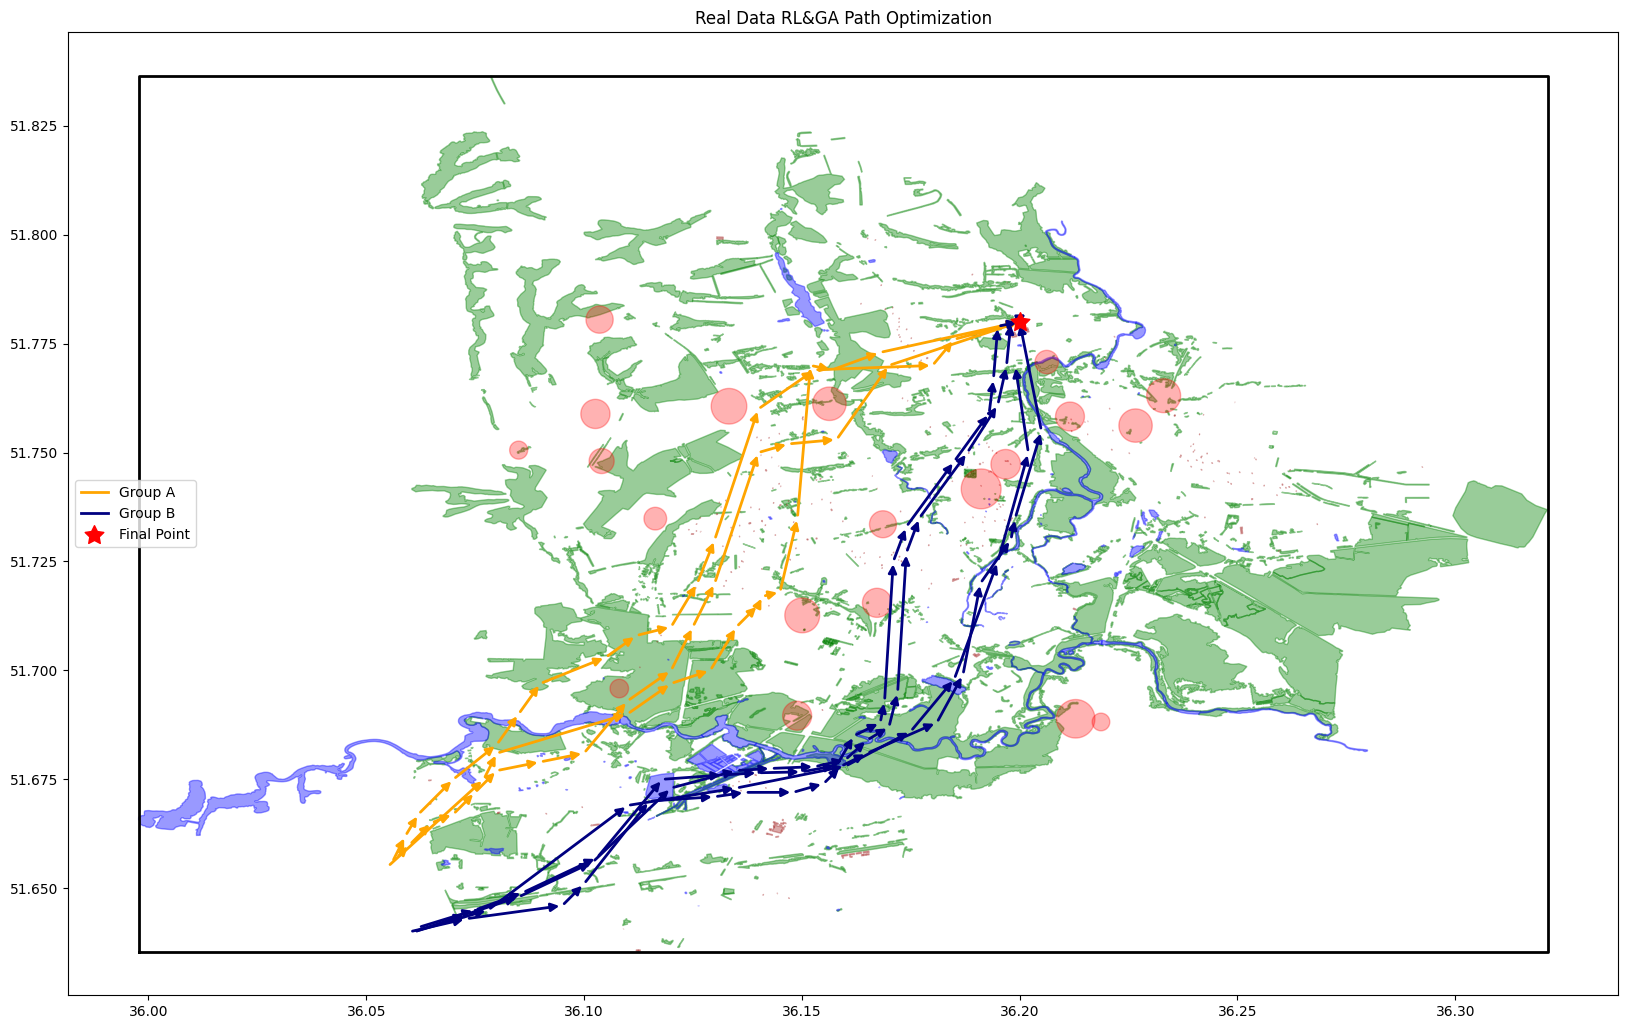

In [258]:
final_training_and_visualization_demo()